In [1]:
import os
os.chdir('/home/harikrishnan/Statathon/nco-semantic-search')

os.getcwd()

'/home/harikrishnan/Statathon/nco-semantic-search'

In [2]:
import pandas as pd

df = pd.read_csv("data/processed/nco_cleaned.csv")

# Merge hierarchy, title, description, and QP info into one text field
def build_text(row):
    fields = [
        f"Division: {row['Division']} {row['Division_Description']}",
        f"Sub-Division: {row['Sub_Division']} {row['Sub_Division_Description']}",
        f"Group: {row['Group']} {row['Group_Description']}",
        f"Family: {row['Family']} {row['Family_Description']}",
        f"Unit: {row['Unit_Code']} {row['Unit_Title']} {row['Unit_Description']}",
        f"NCO 2004 Code: {row['NCO_2004']}",
        f"QP NOS: {row['QP_NOS Reference']} ({row['QP_NOS Name']})",
        f"NSQF Level: {row['NSQF_Level']}"
    ]
    return " | ".join(str(f) for f in fields if pd.notna(f))

df['text'] = df.apply(build_text, axis=1)

df.to_csv("data/processed/nco_ready_for_embedding.csv", index=False)


In [19]:
import pandas as pd
from deep_translator import GoogleTranslator
from tqdm import tqdm

# Load NCO dataset
df = pd.read_csv("common_csv.csv")  # Update to your actual path if needed

# Define Indian languages for translation
languages = {
    "hi": "Hindi",
    "ml": "Malayalam",
    "ta": "Tamil",
    "te": "Telugu",
    "kn": "Kannada",
    "bn": "Bengali",
    "mr": "Marathi"
}

# Templates for real-world user queries
def generate_queries(title, desc):
    base_queries = [
        f"{title}",
        f"What does a {title} do?",
        f"Responsibilities of a {title}",
        f"Role of a {title}",
        f"Work of a {title}",
        f"Jobs similar to {title}",
        f"Who is a {title}?",
        f"Tasks handled by a {title}",
        f"{title} duties in company",
        f"How to become a {title}",
        f"Industry jobs like {title}",
        f"Person managing {desc.split()[0] if desc else 'sector'}"
    ]
    # Add more variations as needed
    return base_queries

output = []

for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing occupations"):
    title = str(row.get('Unit_Title', '')).strip()
    desc = str(row.get('Unit_Description', '')).strip()
    code = str(row.get('Unit_Code', '')).strip()
    occupation_label = f"{code} {title} – {desc[:150]}"
    
    # Create English queries
    queries_en = generate_queries(title, desc)
    for q in queries_en:
        output.append({"query": q, "matching_occupation": occupation_label})
        
    # Translate all queries to target Indian languages
    for lang_code in languages.keys():
        for q in queries_en:
            try:
                translated = GoogleTranslator(source='auto', target=lang_code).translate(q)
                output.append({"query": translated, "matching_occupation": occupation_label})
            except Exception as e:
                print(f"Translation failed for '{q}' to {languages[lang_code]}: {e}")

# Save final dataset
pd.DataFrame(output).to_csv("nco_multilingual_queries.csv", index=False)
print("✅ All queries generated and saved to nco_multilingual_queries.csv")


Processing rows:   0%|          | 0/100 [00:00<?, ?it/s]

transaltion


Processing rows:   1%|          | 1/100 [00:14<23:08, 14.02s/it]

transaltion


Processing rows:   1%|          | 1/100 [00:17<28:57, 17.55s/it]


KeyboardInterrupt: 

In [18]:
import pandas as pd

# Your common unit codes as strings
common_unit_codes = [
    "1120",
    "8153",
    "7531",
    "8152",
    "2210",
    "2320",
    "7511",
    "3110",
    "4110",
    "4210"
]

# Load your NCO CSV
df = pd.read_csv("data/processed/nco_cleaned.csv")

# Convert Unit_Code to string (in case it's numeric)
df['Unit_Code'] = df['Unit_Code'].astype(str)

# Extract the prefix before the decimal point
df['Unit_Prefix'] = df['Unit_Code'].str.split('.').str[0]

# Filter rows where the prefix is in common_unit_codes
df_common = df[df['Unit_Prefix'].isin(common_unit_codes)]
df_common.to_csv("data/processed/common_csv.csv")
print(f"✅ Filtered dataset size: {len(df_common)} rows (only common units)")


✅ Filtered dataset size: 100 rows (only common units)


In [21]:
import pandas as pd
from deep_translator import GoogleTranslator
import time

# Load NCO dataset
df = pd.read_csv("data/processed/common_csv.csv")  # update if needed

# Languages for translation
languages = {
    "hi": "Hindi",
    "ml": "Malayalam",
    "ta": "Tamil",
    "te": "Telugu",
    "kn": "Kannada",
    "bn": "Bengali",
    "mr": "Marathi"
}

# Query templates
def generate_queries(title, desc):
    base_queries = [
        f"{title}",
        f"What does a {title} do?",
        f"Responsibilities of a {title}",
        f"Role of a {title}",
        f"Work of a {title}",
        f"Jobs similar to {title}",
        f"Who is a {title}?",
        f"Tasks handled by a {title}",
        f"{title} duties in company",
        f"How to become a {title}",
        f"Industry jobs like {title}",
        f"Person managing {desc.split()[0] if desc else 'sector'}"
    ]
    return base_queries

# Process only the first row
row = df.iloc[0]
title = str(row.get('Unit_Title', '')).strip()
desc = str(row.get('Unit_Description', '')).strip()
code = str(row.get('Unit_Code', '')).strip()
occupation_label = f"{code} {title} – {desc[:150]}"

start_time = time.perf_counter()

output = []

# English queries
queries_en = generate_queries(title, desc)
for q in queries_en:
    output.append({"query": q, "matching_occupation": occupation_label})

# Translations
for lang_code in languages.keys():
    for q in queries_en:
        try:
            translated = GoogleTranslator(source='auto', target=lang_code).translate(q)
            output.append({"query": translated, "matching_occupation": occupation_label})
        except Exception as e:
            print(f"Translation failed for '{q}' to {languages[lang_code]}: {e}")

end_time = time.perf_counter()

print(f"✅ Time taken for 1 row: {end_time - start_time:.2f} seconds")
print(f"Total queries generated: {len(output)}")


KeyboardInterrupt: 

In [24]:
import pandas as pd
import random
from sentence_transformers import InputExample
import pickle
# ===== CONFIG =====
INPUT_CSV = "data/processed/common_csv.csv"
OUTPUT_PKL = "data/processed/nco_finetune_examples_informal.pkl"

# Common 4-digit NCO family codes
common_unit_codes = [
    "1120",  # Managing Directors & Chief Executives
    "8153",  # Sewing Machine Operators
    "7531",  # Dress Makers / Tailors
    "8152",  # Weavers, Lace (Machine)
    "2210",  # Civil Engineering Professionals
    "2320",  # Mechanical Engineering Professionals
    "7511",  # Motor Vehicle Mechanics and Repairers
    "3110",  # Nursing and Midwifery Professionals
    "4110",  # General and Keyboard Clerks
    "4210"   # Numerical and Material Recording Clerks
]

# ===== HELPER FUNCTIONS =====
def build_matching_text(row):
    """Merge full context for occupation into one text field."""
    fields = [
        f"Division: {row.get('Division','')} {row.get('Division_Description','')}",
        f"Sub-Division: {row.get('Sub_Division','')} {row.get('Sub_Division_Description','')}",
        f"Group: {row.get('Group','')} {row.get('Group_Description','')}",
        f"Family: {row.get('Family','')} {row.get('Family_Description','')}",
        f"Unit: {row.get('Unit_Code','')} {row.get('Unit_Title','')} {row.get('Unit_Description','')}",
        f"NCO 2004 Code: {row.get('NCO_2004','')}",
        f"QP NOS: {row.get('QP_NOS Reference','')} ({row.get('QP_NOS Name','')})",
        f"NSQF Level: {row.get('NSQF_Level','')}"
    ]
    return " | ".join(str(f) for f in fields if pd.notna(f) and str(f).strip() != "")
import re

# Small embedded synonym/colloquial bank for direct replacement
synonym_map = {
    "sewing": ["tailor", "stitching"],
    "machine": ["machin", "equipment"],
    "operator": ["worker", "machinist", "handler", "technician"],
    "director": ["dir", "manager"],
    "executive": ["exec", "officer"],
    "engineer": ["eng", "engg", "technologist"],
    "mechanic": ["fitter", "technician", "repairman"],
    "driver": ["chauffeur"],
    "physician": ["doctor", "dr"],
    "nurse": ["staff nurse", "sister"],
    "cashier": ["cash counter staff", "teller"],
    "clerk": ["assistant", "office staff"],
    "weaver": ["loom operator", "textile worker"]
}

def informal_variants(title):
    """Generate informal, colloquial, and abbreviated variants for a given Unit_Title."""
    
    # Normalize base title: lowercase, strip punctuation
    t = re.sub(r'[^\w\s]', '', title.lower()).strip()
    variants = {t}
    
    # Apply common transformations/substitutions
    if "engineer" in t:
        variants.update([t.replace("engineer", "engg"), t.replace("engineer", "eng")])
    if "director" in t or "executive" in t:
        variants.update([t.replace("executive", "exec"), t.replace("director", "dir")])
    if "machine" in t:
        variants.add(t.replace("machine", "machin"))
    if "sewing" in t:
        variants.add("tailor")
    if "mechanic" in t:
        variants.update(["fitter", "technician", "repairman"])

    # Inject words from synonym_map
    words = t.split()
    for i, w in enumerate(words):
        if w in synonym_map:
            for syn in synonym_map[w]:
                # Replace word with synonym in the whole title
                var = words.copy()
                var[i] = syn
                variants.add(" ".join(var))
                # Add synonym as standalone simple search word
                variants.add(syn)

    # Add plural forms
    for v in list(variants):
        if not v.endswith('s'):
            variants.add(v + "s")
    
    # Add split words separately (one-word variants)
    variants.update(words)
    
    # Remove duplicates, strip spaces
    clean_variants = sorted({v.strip() for v in variants if v.strip() != ""})
    
    return clean_variants
# ===== LOAD DATA =====
# ===== LOAD DF AND FILTER =====
df = pd.read_csv(INPUT_CSV)
df['Unit_Code'] = df['Unit_Code'].astype(str)
df['Unit_Prefix'] = df['Unit_Code'].str.split('.').str[0]
df_common = df[df['Unit_Prefix'].isin(common_unit_codes)].copy()
print(f"✅ Filtered to {len(df_common)} rows from common NCO families")

# ===== GENERATE TRAINING EXAMPLES =====
pairs = []
for idx, row in df_common.iterrows():
    occ_text = build_matching_text(row)
    queries = informal_variants(row["Unit_Title"])
    for q in queries:
        # Positive
        pairs.append(InputExample(texts=[q, occ_text], label=1.0))
        # Negative
        neg_row = df_common.sample(n=1).iloc[0]
        while neg_row["Unit_Code"] == row["Unit_Code"]:
            neg_row = df_common.sample(n=1).iloc[0]
        neg_text = build_matching_text(neg_row)
        pairs.append(InputExample(texts=[q, neg_text], label=0.0))

print(f"Total examples generated: {len(pairs)}")

# ===== SAVE =====
with open(OUTPUT_PKL, "wb") as f:
    pickle.dump(pairs, f)

print(f"✅ Saved {len(pairs)} examples to {OUTPUT_PKL}")


✅ Filtered to 100 rows from common NCO families
Total examples generated: 2130
✅ Saved 2130 examples to data/processed/nco_finetune_examples_informal.pkl


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import torch
torch.cuda.empty_cache()

print("Is CUDA available?", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("CUDA memory allocated:", torch.cuda.memory_allocated())


Is CUDA available? False
CUDA device count: 0
CUDA memory allocated: 0


In [2]:
import os
os.chdir('/home/harikrishnan/Statathon/nco-semantic-search')

os.getcwd()

'/home/harikrishnan/Statathon/nco-semantic-search'

In [4]:
from sentence_transformers import SentenceTransformer, losses
from torch.utils.data import DataLoader
import pickle
import math

DATASET_PKL = "data/processed/nco_finetune_examples_informal.pkl"
OUTPUT_MODEL_DIR = "models/labse_nco_finetuned"
BATCH_SIZE = 1
EPOCHS = 2
LEARNING_RATE = 2e-5
WARMUP_RATIO = 0.1

# Load fine-tuning examples
with open(DATASET_PKL, "rb") as f:
    train_examples = pickle.load(f)

print(f"✅ Loaded {len(train_examples)} examples")
train_examples = train_examples[:1]
# Load LaBSE (change device to 'cuda' if GPU available)
model = SentenceTransformer("sentence-transformers/LaBSE", device="cpu")

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=EPOCHS,
    warmup_steps=warmup_steps,
    optimizer_params={"lr": LEARNING_RATE},
    output_path=OUTPUT_MODEL_DIR,
    show_progress_bar=True
)

print(f"✅ Fine-tuned model saved to {OUTPUT_MODEL_DIR}")


✅ Loaded 2130 examples


In [6]:
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=BATCH_SIZE)

train_loss = losses.CosineSimilarityLoss(model)
warmup_steps = math.ceil(len(train_dataloader) * EPOCHS * WARMUP_RATIO)
print(f"Warmup steps: {warmup_steps}")


Warmup steps: 426


In [7]:
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=EPOCHS,
    warmup_steps=warmup_steps,
    optimizer_params={"lr": LEARNING_RATE},
    output_path=OUTPUT_MODEL_DIR,
    show_progress_bar=True
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 3.69 GiB of which 14.94 MiB is free. Including non-PyTorch memory, this process has 3.65 GiB memory in use. Of the allocated memory 3.49 GiB is allocated by PyTorch, and 69.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [3]:
%pip install langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 486.6 kB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941216 sha256=8cba666f5b29b51898f3471ded069500d87bcd6729ec34fb284bda5d38a9351b
  Stored in directory: /home/harikrishnan/.cache/pip/wheels/3c/bc/9d/266e27289b9019680d65d9b608c37bff1eff565b001c977ec5
Successfully built langid
Note: you may need to restart the kernel to use updated packages.


In [4]:
from langdetect import detect, DetectorFactory
from sklearn.metrics import accuracy_score

DetectorFactory.seed = 0  # for reproducibility

# Prepare labeled sentences: (sentence, true_lang_code)
test_data = [
    # English (10)
    ("Statistical Data Analyst", "en"),
    ("Data Science Consultant", "en"),
    ("Retail Bank Cashier", "en"),
    ("Healthcare Support Worker", "en"),
    ("Registered Nurse", "en"),
    ("Automobile Mechanic", "en"),
    ("Application Software Engineer", "en"),
    ("Elementary School Teacher", "en"),
    ("Executive Chef", "en"),
    ("Machine Learning Engineer", "en"),

    # Hindi (10)
    ("सांख्यिकी डेटा विश्लेषक", "hi"),
    ("डेटा विज्ञान सलाहकार", "hi"),
    ("बैंक कैशियर", "hi"),
    ("स्वास्थ्य सहायक", "hi"),
    ("पंजीकृत नर्स", "hi"),
    ("गाड़ी मैकेनिक", "hi"),
    ("सॉफ़्टवेयर इंजीनियर", "hi"),
    ("प्राथमिक विद्यालय शिक्षक", "hi"),
    ("मुख्य रसोइया", "hi"),
    ("मशीन लर्निंग इंजीनियर", "hi"),

    # Malayalam (10)
    ("സംഖ്യാ ഡാറ്റ വിശകലന വിദഗ്ധൻ", "ml"),
    ("ഡാറ്റ സയൻസ് കൺസൾട്ടന്റ്", "ml"),
    ("ബാങ്ക് കാഷിയർ", "ml"),
    ("ആരോഗ്യ സഹായി", "ml"),
    ("രജിസ്റ്റർഡ് നഴ്‌സ്", "ml"),
    ("വാഹനം മെക്കാനിക്ക്", "ml"),
    ("ആപ്ലിക്കേഷൻ സോഫ്റ്റ്‌വെയർ എൻജിനീയർ", "ml"),
    ("പ്രാഥമിക വിദ്യാലയം അധ്യാപകൻ", "ml"),
    ("എക്സിക്യൂട്ടീവ് ഷെഫ്", "ml"),
    ("മെഷീൻ ലേണിംഗ് എഞ്ചിനീയർ", "ml"),

    # Tamil (10)
    ("கணினி தரவு பகுப்பாய்வு வல்லுநர்", "ta"),
    ("டேட்டா சயின்ஸ் ஆலோசகர்", "ta"),
    ("வங்கிக் காசியர்", "ta"),
    ("சுகாதார உதவியாளர்", "ta"),
    ("பதிவு செய்யப்பட்ட செவிலியர்", "ta"),
    ("வாகன மெக்கானிக்", "ta"),
    ("மென்பொருள் பொறியாளர்", "ta"),
    ("ஆரம்பப் பள்ளி ஆசிரியர்", "ta"),
    ("முதன்மை சமையல்காரர்", "ta"),
    ("மெஷின் லர்னிங் பொறியாளர்", "ta"),

    # Telugu (10)
    ("సంఖ్యాత్మక డేటా విశ్లేషకుడు", "te"),
    ("డేటా సైన్స్ కన్సల్టెంట్", "te"),
    ("బ్యాంకు కాషియర్", "te"),
    ("ఆరోగ్య సహాయకుడు", "te"),
    ("నమోదు నర్సు", "te"),
    ("యంత్రం మెకానిక్", "te"),
    ("సాఫ్ట్వేర్ ఇంజినీర్", "te"),
    ("ప్రాథమిక పాఠశాల ఉపాధ్యాయుడు", "te"),
    ("ప్రధాన వంటకారు", "te"),
    ("మిషన్ లెర్నింగ్ ఇంజినీర్", "te"),

    # Kannada (10)
    ("ಸಂಖ್ಯಾ ಡೇಟಾ ವಿಶ್ಲೇಷಕ", "kn"),
    ("ಡೇಟಾ ಸೈನ್ಸ್ ಸಲಹೆಗಾರ", "kn"),
    ("ಬ್ಯಾಂಕ್ ಕ್ಯಾಸಿಯರ್", "kn"),
    ("ಆರೋಗ್ಯ ಸಹಾಯಕ", "kn"),
    ("ನೋಂದಣಿಯ ನರ್ಸ್", "kn"),
    ("ಕಾರು ಮೆಕಾನಿಕ್", "kn"),
    ("ಸಾಫ್ಟ್‌ವೇರ್ ಇಂಜಿನಿಯರ್", "kn"),
    ("ಪ್ರಾಥಮಿಕ ಶಾಲೆ ಶಿಕ್ಷಕ", "kn"),
    ("ಮುಖ್ಯ ಬಂತುಹಾರ", "kn"),
    ("ಮೆಷಿನ್ ಲರ್ನಿಂಗ್ ಇಂಜಿನಿಯರ್", "kn"),

    # Bengali (10)
    ("পরিসংখ্যান ডেটা বিশ্লেষক", "bn"),
    ("ডেটা সায়েন্স পরামর্শক", "bn"),
    ("ব্যাংক ক্যাশিয়ার", "bn"),
    ("স্বাস্থ্য সহায়ক", "bn"),
    ("নিবন্ধিত নার্স", "bn"),
    ("গাড়ি মেকানিক", "bn"),
    ("সফটওয়্যার ইঞ্জিনিয়ার", "bn"),
    ("প্রাথমিক বিদ্যালয়ের শিক্ষক", "bn"),
    ("প্রধান রাঁধুনি", "bn"),
    ("মেশিন লার্নিং ইঞ্জিনিয়ার", "bn"),

    # Marathi (10)
    ("सांख्यिकी डेटा विश्लेषक", "mr"),
    ("डेटा सायन्स सल्लागार", "mr"),
    ("बँक कॅशियर", "mr"),
    ("आरोग्य सहाय्यक", "mr"),
    ("नोंदणीकृत नर्स", "mr"),
    ("गाडी मॅकेनिक", "mr"),
    ("सॉफ़्टवेअर अभियंता", "mr"),
    ("प्राथमिक शाळेचा शिक्षक", "mr"),
    ("मुख्य स्वयंपाकी", "mr"),
    ("मशीन लर्निंग अभियंता", "mr"),
]

true_labels = []
predicted_labels = []

for sentence, true_lang in test_data:
    try:
        pred_lang = detect(sentence)
    except:
        pred_lang = "error"
    true_labels.append(true_lang)
    predicted_labels.append(pred_lang)

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Langdetect accuracy: {accuracy:.2%}")

# Optional: show detailed results
for sent, true_l, pred_l in zip([d[0] for d in test_data], true_labels, predicted_labels):
    if true_l!=pred_l:
        print(f"Sentence: {sent[:30]:30} True: {true_l} Predicted: {pred_l}")


Langdetect accuracy: 85.00%
Sentence: Data Science Consultant        True: en Predicted: it
Sentence: Registered Nurse               True: en Predicted: de
Sentence: Automobile Mechanic            True: en Predicted: ro
Sentence: सांख्यिकी डेटा विश्लेषक        True: hi Predicted: mr
Sentence: डेटा विज्ञान सलाहकार           True: hi Predicted: ne
Sentence: स्वास्थ्य सहायक                True: hi Predicted: ne
Sentence: प्राथमिक विद्यालय शिक्षक       True: hi Predicted: ne
Sentence: मुख्य रसोइया                   True: hi Predicted: mr
Sentence: नोंदणीकृत नर्स                 True: mr Predicted: hi
Sentence: गाडी मॅकेनिक                   True: mr Predicted: ne
Sentence: सॉफ़्टवेअर अभियंता             True: mr Predicted: hi
Sentence: मुख्य स्वयंपाकी                True: mr Predicted: hi


In [5]:
true_labels = []
predicted_labels = []
for sentence, true_lang in test_data:
    try:
        pred_lang = detect(sentence)  # or your detection function
    except:
        pred_lang = "error"
    true_labels.append(true_lang)
    predicted_labels.append(pred_lang)

# Overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Overall accuracy: {accuracy:.2%}")

# Now analyze misclassifications
# Define sets for grouping
english_set = {"en"}
indic_set = {"hi", "ta", "te", "ml", "kn", "bn", "mr"}  # add as needed

# Counters
misclassified_en_as_indic = 0
misclassified_indic_as_en = 0
misclassified_indic_as_other_indic = 0

total_en = sum(1 for l in true_labels if l in english_set)
total_indic = sum(1 for l in true_labels if l in indic_set)

for true_l, pred_l in zip(true_labels, predicted_labels):
    if true_l in english_set:
        if pred_l in indic_set:
            misclassified_en_as_indic += 1
    elif true_l in indic_set:
        if pred_l in english_set:
            misclassified_indic_as_en += 1
        elif pred_l in indic_set and pred_l != true_l:
            misclassified_indic_as_other_indic += 1

print(f"English misclassified as Indic: {misclassified_en_as_indic}/{total_en} ({misclassified_en_as_indic/total_en:.2%})")
print(f"Indic misclassified as English: {misclassified_indic_as_en}/{total_indic} ({misclassified_indic_as_en/total_indic:.2%})")
print(f"Indic misclassified as other Indic: {misclassified_indic_as_other_indic}/{total_indic} ({misclassified_indic_as_other_indic/total_indic:.2%})")

Overall accuracy: 85.00%
English misclassified as Indic: 0/10 (0.00%)
Indic misclassified as English: 0/70 (0.00%)
Indic misclassified as other Indic: 5/70 (7.14%)


In [4]:
%pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 379.3 kB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from nltk.corpus import wordnet
import nltk

# Download WordNet if not already
nltk.download('wordnet')
nltk.download('omw-1.4')

# Function to get synonyms from WordNet
def get_synonyms(word, max_synonyms=3):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name().replace("_", " "))
            if len(synonyms) >= max_synonyms:
                break
        if len(synonyms) >= max_synonyms:
            break
    if not synonyms:
        synonyms.add(word)
    return list(synonyms)

# Load your CSV
csv_path = "/home/harikrishnan/Statathon/nco-semantic-search/data/processed/nco_cleaned.csv"
df = pd.read_csv(csv_path)

max_allowed_combinations = 1000  # threshold to warn about explosion

for title in df['Unit_Title'].dropna().unique():
    words = title.lower().split()
    word_syn_counts = [len(get_synonyms(w)) for w in words]
    
    # Compute the total number of phrase combinations
    total_combinations = 1
    for c in word_syn_counts:
        total_combinations *= c

    if total_combinations > max_allowed_combinations:
        print(f"[WARNING] '{title}' will produce {total_combinations} combinations! Consider limiting synonyms.")
        


[WARNING] 'Master Official Referee and Registrar in Equity and Commissioner for taking Accounts (High Court)' will produce 4374 combinations! Consider limiting synonyms.
[WARNING] 'Supervisors and Foremen in Mining and Mineral Processing Plant Operation Activities, Other' will produce 6561 combinations! Consider limiting synonyms.
[WARNING] 'Supervisor and Foreman, Petroleum Refining and Related Activities/Operator/Engineering Assistant (Mechanical/electrical/civil/chemic al) related activities' will produce 2187 combinations! Consider limiting synonyms.
[WARNING] 'Supervisor and Foreman, Carpentry, Cabinet Making and Related Wood Working Processes' will produce 2187 combinations! Consider limiting synonyms.
[WARNING] 'Supervisors and Foremen and Related Trades Workers in Painting, Building Structure Cleaning, Other' will produce 19683 combinations! Consider limiting synonyms.
[WARNING] 'Gas Metal Arc Welder/Metal Inert Gas/Metal Active Gas/Gas Metal Arc Welder (MIG/MAG/GMAW)' will pro

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/harikrishnan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/harikrishnan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
import zipfile
import tiktoken  # OpenAI tokenizer library

zip_path = "../nco-semantic-search.zip"
output_file = "../nco_zip_contents.txt"

all_text = ""
with zipfile.ZipFile(zip_path, "r") as zf:
    for file_info in zf.infolist():
        if file_info.is_dir():
            continue
        filename = file_info.filename
        all_text += f"\n==== {filename} ====\n"
        try:
            with zf.open(file_info) as f:
                content = f.read().decode("utf-8")
                all_text += content
        except UnicodeDecodeError:
            all_text += "[Binary file content omitted]\n"

# Step 2: Save to text file
with open(output_file, "w", encoding="utf-8") as out:
    out.write(all_text)

# Step 3: Count tokens using tiktoken
# Replace "cl100k_base" with the model you plan to use, e.g., "gpt-4o-mini"
encoding = tiktoken.get_encoding("cl100k_base")
tokens = encoding.encode(all_text)

print(f"Total tokens in {output_file}: {len(tokens)}")


Total tokens in ../nco_zip_contents.txt: 11018610


In [1]:
import langid
from sklearn.metrics import accuracy_score

# Prepare labeled sentences: (sentence, true_lang_code)
test_data = [
    # English (10)
    ("Statistical Data Analyst", "en"),
    ("Data Science Consultant", "en"),
    ("Retail Bank Cashier", "en"),
    ("Healthcare Support Worker", "en"),
    ("Registered Nurse", "en"),
    ("Automobile Mechanic", "en"),
    ("Application Software Engineer", "en"),
    ("Elementary School Teacher", "en"),
    ("Executive Chef", "en"),
    ("Machine Learning Engineer", "en"),

    # Hindi (10)
    ("सांख्यिकी डेटा विश्लेषक", "hi"),
    ("डेटा विज्ञान सलाहकार", "hi"),
    ("बैंक कैशियर", "hi"),
    ("स्वास्थ्य सहायक", "hi"),
    ("पंजीकृत नर्स", "hi"),
    ("गाड़ी मैकेनिक", "hi"),
    ("सॉफ़्टवेयर इंजीनियर", "hi"),
    ("प्राथमिक विद्यालय शिक्षक", "hi"),
    ("मुख्य रसोइया", "hi"),
    ("मशीन लर्निंग इंजीनियर", "hi"),

    # Malayalam (10)
    ("സംഖ്യാ ഡാറ്റ വിശകലന വിദഗ്ധൻ", "ml"),
    ("ഡാറ്റ സയൻസ് കൺസൾട്ടന്റ്", "ml"),
    ("ബാങ്ക് കാഷിയർ", "ml"),
    ("ആരോഗ്യ സഹായി", "ml"),
    ("രജിസ്റ്റർഡ് നഴ്‌സ്", "ml"),
    ("വാഹനം മെക്കാനിക്ക്", "ml"),
    ("ആപ്ലിക്കേഷൻ സോഫ്റ്റ്‌വെയർ എൻജിനീയർ", "ml"),
    ("പ്രാഥമിക വിദ്യാലയം അധ്യാപകൻ", "ml"),
    ("എക്സിക്യൂട്ടീവ് ഷെഫ്", "ml"),
    ("മെഷീൻ ലേണിംഗ് എഞ്ചിനീയർ", "ml"),

    # Tamil (10)
    ("கணினி தரவு பகுப்பாய்வு வல்லுநர்", "ta"),
    ("டேட்டா சயின்ஸ் ஆலோசகர்", "ta"),
    ("வங்கிக் காசியர்", "ta"),
    ("சுகாதார உதவியாளர்", "ta"),
    ("பதிவு செய்யப்பட்ட செவிலியர்", "ta"),
    ("வாகன மெக்கானிக்", "ta"),
    ("மென்பொருள் பொறியாளர்", "ta"),
    ("ஆரம்பப் பள்ளி ஆசிரியர்", "ta"),
    ("முதன்மை சமையல்காரர்", "ta"),
    ("மெஷின் லர்னிங் பொறியாளர்", "ta"),

    # Telugu (10)
    ("సంఖ్యాత్మక డేటా విశ్లేషకుడు", "te"),
    ("డేటా సైన్స్ కన్సల్టెంట్", "te"),
    ("బ్యాంకు కాషియర్", "te"),
    ("ఆరోగ్య సహాయకుడు", "te"),
    ("నమోదు నర్సు", "te"),
    ("యంత్రం మెకానిక్", "te"),
    ("సాఫ్ట్వేర్ ఇంజినీర్", "te"),
    ("ప్రాథమిక పాఠశాల ఉపాధ్యాయుడు", "te"),
    ("ప్రధాన వంటకారు", "te"),
    ("మిషన్ లెర్నింగ్ ఇంజినీర్", "te"),

    # Kannada (10)
    ("ಸಂಖ್ಯಾ ಡೇಟಾ ವಿಶ್ಲೇಷಕ", "kn"),
    ("ಡೇಟಾ ಸೈನ್ಸ್ ಸಲಹೆಗಾರ", "kn"),
    ("ಬ್ಯಾಂಕ್ ಕ್ಯಾಸಿಯರ್", "kn"),
    ("ಆರೋಗ್ಯ ಸಹಾಯಕ", "kn"),
    ("ನೋಂದಣಿಯ ನರ್ಸ್", "kn"),
    ("ಕಾರು ಮೆಕಾನಿಕ್", "kn"),
    ("ಸಾಫ್ಟ್‌ವೇರ್ ಇಂಜಿನಿಯರ್", "kn"),
    ("ಪ್ರಾಥಮಿಕ ಶಾಲೆ ಶಿಕ್ಷಕ", "kn"),
    ("ಮುಖ್ಯ ಬಂತುಹಾರ", "kn"),
    ("ಮೆಷಿನ್ ಲರ್ನಿಂಗ್ ಇಂಜಿನಿಯರ್", "kn"),

    # Bengali (10)
    ("পরিসংখ্যান ডেটা বিশ্লেষক", "bn"),
    ("ডেটা সায়েন্স পরামর্শক", "bn"),
    ("ব্যাংক ক্যাশিয়ার", "bn"),
    ("স্বাস্থ্য সহায়ক", "bn"),
    ("নিবন্ধিত নার্স", "bn"),
    ("গাড়ি মেকানিক", "bn"),
    ("সফটওয়্যার ইঞ্জিনিয়ার", "bn"),
    ("প্রাথমিক বিদ্যালয়ের শিক্ষক", "bn"),
    ("প্রধান রাঁধুনি", "bn"),
    ("মেশিন লার্নিং ইঞ্জিনিয়ার", "bn"),

    # Marathi (10)
    ("सांख्यिकी डेटा विश्लेषक", "mr"),
    ("डेटा सायन्स सल्लागार", "mr"),
    ("बँक कॅशियर", "mr"),
    ("आरोग्य सहाय्यक", "mr"),
    ("नोंदणीकृत नर्स", "mr"),
    ("गाडी मॅकेनिक", "mr"),
    ("सॉफ़्टवेअर अभियंता", "mr"),
    ("प्राथमिक शाळेचा शिक्षक", "mr"),
    ("मुख्य स्वयंपाकी", "mr"),
    ("मशीन लर्निंग अभियंता", "mr"),
]


true_labels = []
predicted_labels = []
confidences = []

for sentence, true_lang in test_data:
    pred_lang, conf = langid.classify(sentence)
    true_labels.append(true_lang)
    predicted_labels.append(pred_lang)
    confidences.append(conf)

from pprint import pprint

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Langid accuracy: {accuracy:.2%}\n")
import math
def logprob_to_prob(logprob):
    # Convert logprob (negative) to positive probability between 0 and 1
    return math.exp(logprob)
print("Detailed results:")
for sent, true_l, pred_l, conf in zip([d[0] for d in test_data], true_labels, predicted_labels, confidences):
    print(f"Sentence: {sent[:30]:30} True: {true_l:3} Predicted: {pred_l:3} Confidence: {logprob_to_prob(conf):.2f}")


Langid accuracy: 83.75%

Detailed results:
Sentence: Statistical Data Analyst       True: en  Predicted: en  Confidence: 10.88
Sentence: Data Science Consultant        True: en  Predicted: en  Confidence: 15.96
Sentence: Retail Bank Cashier            True: en  Predicted: en  Confidence: 8620.00
Sentence: Healthcare Support Worker      True: en  Predicted: ro  Confidence: 0.05
Sentence: Registered Nurse               True: en  Predicted: en  Confidence: 12.24
Sentence: Automobile Mechanic            True: en  Predicted: it  Confidence: 2.84
Sentence: Application Software Engineer  True: en  Predicted: en  Confidence: 0.00
Sentence: Elementary School Teacher      True: en  Predicted: en  Confidence: 0.05
Sentence: Executive Chef                 True: en  Predicted: en  Confidence: 8620.00
Sentence: Machine Learning Engineer      True: en  Predicted: en  Confidence: 0.00
Sentence: सांख्यिकी डेटा विश्लेषक        True: hi  Predicted: mr  Confidence: 0.00
Sentence: डेटा विज्ञान सलाहकार     

In [1]:
import pandas as pd
import re
import unicodedata

# Load the CSV
df = pd.read_csv('/home/harikrishnan/Statathon/nco-semantic-search/data/processed/nco_cleaned.csv')

# List the text columns you want to normalize
text_columns = [
    'Unit_Title', 'Unit_Description', 'Division', 'Division_Description',
    'Sub_Division', 'Sub_Division_Description', 'Group', 'Group_Description',
    'Family_Description', 'text1'
    # Add/remove columns as needed
]

def normalize_text(text):
    if pd.isna(text): return ""
    text = str(text)
    # Lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Standardize punctuation spacing
    text = re.sub(r'\s*([,./\-:;])\s*', r'\1 ', text)
    text = re.sub(r'\s+', ' ', text)
    # Remove non-ASCII/control characters but keep Indian languages
    text = ''.join([c for c in text if unicodedata.category(c)[0] != 'C'])
    # Remove leading/trailing spaces
    text = text.strip()
    return text

# Apply normalization
for col in text_columns:
    if col in df:
        df[col] = df[col].apply(normalize_text)

# Save back to CSV (or a new one, to be safe)
df.to_csv('/home/harikrishnan/Statathon/nco-semantic-search/data/processed/nco_cleaned_normalized.csv', index=False)
print("✅ Text normalization complete!")



✅ Text normalization complete!


In [2]:
from datasets import Dataset

# Create a simple dictionary with one column
data_dict = {
    "sentence": ["Hello world!", "This is a test.", "Dataset import works."]
}

# Create Dataset from the dictionary
dataset = Dataset.from_dict(data_dict)

# Print the dataset to verify
print(dataset)
print(dataset[0])  # print first entry


Dataset({
    features: ['sentence'],
    num_rows: 3
})
{'sentence': 'Hello world!'}


In [6]:
import pandas as pd
from collections import Counter
import nltk
from nltk.corpus import wordnet
import json

# Download WordNet if not already
nltk.download('wordnet')

# Your list of stopwords to exclude
stopwords = {'and', 'of', 'to', 'or', 'in', 'for', 'may', 'the', 'on', 'as', 'with', 'by', 'other'}
extra_stopwords = {
    'qp', 'nos', 'etc', 'etc.', 'is', 'be', 'them', 'from', 'such', 'according',
    'at', 'it', 'reference', 'pack', 'name', 'qualification', 'details:', 'nsqf',
    'that', 'their', 'through', 'various', 'type', 'necessary', 'ensure', 'are',
    'specified', 'makes', 'volum', 'divison', 'different', 'over', 'places', 'all',
    'starts', 'studies', 'not', 'examines', 'also', '4', 'prescribed', 'working',
    'related', 'include', 'one', 'which', 'when', 'make', 'are', 'under',
    
    'using', 'into', 'if', 'machine.', 'out', 'a', 'after', 'elsewhere', '7',
    'up', 'classified.', 'new', 'necessary.', 'required.', 'gets', 'any', 'its'
    ,'etc.,', 'manager,', 'during', 'end'

}

stopwords = {'and', 'of', 'to', 'or', 'in', 'for', 'may', 'the', 'on', 'as', 'with', 'by', 'other'}
stopwords.update(extra_stopwords)

# Load your NCO cleaned CSV
df = pd.read_csv("data/processed/nco_cleaned.csv")

# Collect words from Unit_Title and Unit_Description
titles = df['Unit_Title'].dropna().str.lower().str.split().tolist()
descriptions = df['Unit_Description'].dropna().str.lower().str.split().tolist()

# Flatten and combine, excluding stopwords
all_words = [
    word for sublist in titles + descriptions for word in sublist 
    if word not in stopwords
]

# Count frequency and pick top N (e.g., 100)
word_counts = Counter(all_words)
top_n = 100
nco_terms = [word for word, count in word_counts.most_common(top_n)]

print("Top NCO terms extracted (stopwords removed):", nco_terms)


Top NCO terms extracted (stopwords removed): ['machine', 'level', 'required', 'work', 'operator', 'hand', 'equipment', 'water', 'metal', 'checks', 'parts', 'operates', 'ensures', 'material', 'designated', 'sets', 'removes', 'maintains', 'responsible', 'supervises', 'adjusts', 'engaged', 'paper', 'prepares', 'repairs', 'records', 'workers', 'proper', 'cleans', 'tests', 'production', 'oil', 'cuts', 'cutting', 'controls', 'individual', 'conducts', 'making', 'collects', 'control', 'design', 'quality', 'sales', 'surface', 'chemical', 'engine', 'technician', 'engineer', 'determine', 'selects', 'materials', 'product', 'process', 'products', 'data', 'use', 'glass', 'correct', 'position', 'operations', 'size', 'wood', 'desired', 'general', 'activities', 'arranges', 'electrical', 'maintenance', 'power', 'observes', 'service', 'performs', 'machines', 'flow', 'operating', 'operation', 'test', 'research', 'goods', 'keeps', 'components', 'reports', 'supervisor', 'air', 'solution', 'cut', 'directs', 

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/harikrishnan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            # Avoid adding the original word twice
            lemma_name = lemma.name().replace('_', ' ')
            if lemma_name != word:
                synonyms.add(lemma_name)
    return list(synonyms)

synonym_dict = {}

for term in nco_terms:
    synonym_dict[term] = get_synonyms(term)

print("Sample synonyms for terms:")
for term in nco_terms[:10]:
    print(f"{term}: {synonym_dict[term]}")


Sample synonyms for terms:
machine: ['car', 'political machine', 'automobile', 'auto', 'simple machine', 'motorcar']
level: ['stage', 'pull down', 'take down', 'floor', 'even', 'flat', 'tied', 'tear down', 'unwavering', 'story', 'point', 'plane', 'spirit level', 'rase', 'charge', 'horizontal surface', 'even out', 'degree', 'tier', 'flush', 'stratum', 'raze', 'dismantle', 'level off', 'grade', 'layer', 'storey']
required: ['want', 'require', 'needful', 'take', 'requisite', 'call for', 'mandatory', 'involve', 'demand', 'command', 'need', 'compulsory', 'necessitate', 'ask', 'needed', 'expect', 'postulate']
work: ['turn', 'make for', 'put to work', 'body of work', 'act', 'mould', 'knead', 'study', 'bring', 'oeuvre', 'process', 'do work', 'function', 'exploit', 'shape', 'exercise', 'wreak', 'work on', 'ferment', 'workplace', 'go', 'puzzle out', 'operate', 'run', 'influence', 'solve', 'make', 'piece of work', 'play', 'act upon', 'forge', 'figure out', 'lick', 'sour', 'work out', 'form', 'cro

In [23]:
synonym_dict = {
    "machine": ["equipment", "apparatus", "device", "mechanism", "machinery", "tool"],
    "level": ["stage", "grade", "tier", "degree", "rank", "step"],
    "required": ["needed", "necessary", "mandatory", "compulsory", "essential", "obligatory"],
    "work": ["operate", "function", "perform", "labor", "task", "job", "duty", "employment"],
    "operator": ["machinist", "controller", "handler", "technician", "worker", "executor"],
    "hand": ["assistant", "helper", "support", "worker", "laborer", "attendant"],
    "equipment": ["tools", "machinery", "gear", "instrument", "apparatus", "device"],
    "water": ["irrigation", "H2O", "fluid", "liquid", "supply", "hydration"],
    "metal": ["alloy", "iron", "steel", "metallic", "ferrous", "nonferrous"],
    "checks": ["inspections", "verifications", "tests", "controls", "examinations", "reviews"],
    "finance": ["funds", "money", "capital", "investment", "banking", "accounts"],
    "loan": ["credit", "advance", "mortgage", "financing", "borrowed funds"],
    "bank": ["financial institution", "lender", "credit union", "savings institution"],
    "supervisor": ["manager", "overseer", "foreman", "administrator", "controller"],
    "engineer": ["technologist", "designer", "developer", "specialist", "technician"],
    "technician": ["operator", "mechanic", "specialist", "technologist", "assistant"],
    "manager": ["administrator", "supervisor", "director", "leader", "executive"],
    "assistant": ["helper", "aide", "support staff", "associate", "junior worker"],
    "health": ["medical", "healthcare", "wellness", "clinical", "patient care"],
    "safety": ["security", "protection", "precaution", "risk management", "hazard control"],
    "legal": ["law", "judicial", "legislative", "regulatory", "compliance"],
    "administration": ["management", "governance", "operation", "organization"],
    "production": ["manufacturing", "fabrication", "creation", "assembly", "processing"],
    "quality": ["standard", "grade", "excellence", "caliber", "specification"],
    "control": ["regulation", "monitoring", "supervision", "inspection", "management"],
    "maintenance": ["repair", "upkeep", "service", "overhaul", "preservation"],
    "testing": ["inspection", "examination", "evaluation", "analysis", "verification"],
    "research": ["study", "investigation", "analysis", "exploration", "inquiry"],
    "support": ["assistance", "help", "aid", "backing", "service"],
    "sales": ["marketing", "distribution", "retail", "trade", "commerce"],
    "communication": ["interaction", "correspondence", "conversation", "liaison", "messaging"],
    "information": ["data", "knowledge", "facts", "details", "intelligence"],
    "technical": ["specialized", "scientific", "mechanical", "technological", "industrial"],
}


In [24]:
synonym_corpus = []

for main_word, synonyms in synonym_dict.items():
    synonym_corpus.append(main_word)
    synonym_corpus.extend(synonyms)

# Remove duplicates
synonym_corpus = list(set(synonym_corpus))

print(f"Synonym corpus size: {len(synonym_corpus)}")
print(synonym_corpus[:20])


Synonym corpus size: 186
['specialist', 'data', 'medical', 'production', 'evaluation', 'standard', 'financing', 'developer', 'security', 'credit union', 'knowledge', 'reviews', 'mechanic', 'industrial', 'ferrous', 'savings institution', 'apparatus', 'operation', 'banking', 'healthcare']


In [25]:
import streamlit as st

st.write("Before rerun")

if st.button("Rerun"):
    st.experimental_rerun()

st.write("After rerun")


2025-08-09 00:34:38.429 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-09 00:34:38.487 
  command:

    streamlit run /home/harikrishnan/venvs/statathon_env/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-08-09 00:34:38.488 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-09 00:34:38.488 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-09 00:34:38.489 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-09 00:34:38.489 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-09 00:34:38.490 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-09 00:34:38.49

In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv('data/processed/hierarchy_with_qps_clean.csv')

# Drop rows missing critical data
df = df.dropna(subset=['Unit_Title', 'Unit_Description'])

# Create unified text field for embeddings
df['text'] = (df['Unit_Title'] + ' ' + df['Unit_Description']).str.lower()
df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True)

# Save cleaned dataset
df.to_csv('data/processed/nco_cleaned.csv', index=False)


In [8]:
import pandas as pd

# Load the CSV
file_path = '/home/harikrishnan/Statathon/nco-semantic-search/data/processed/nco_cleaned.csv'
df = pd.read_csv(file_path)

# Drop the "text" column if it exists
if 'text' in df.columns:
    df = df.drop(columns=['text'])

# Save the updated dataframe back to the same CSV file
df.to_csv(file_path, index=False)

print("The 'text' column has been deleted and the file saved.")


The 'text' column has been deleted and the file saved.


In [4]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer('all-MiniLM-L6-v2')

texts = df['text'].tolist()
embeddings = model.encode(texts, show_progress_bar=True)

np.save('embeddings/nco_embeddings.npy', embeddings)


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/106 [00:00<?, ?it/s]

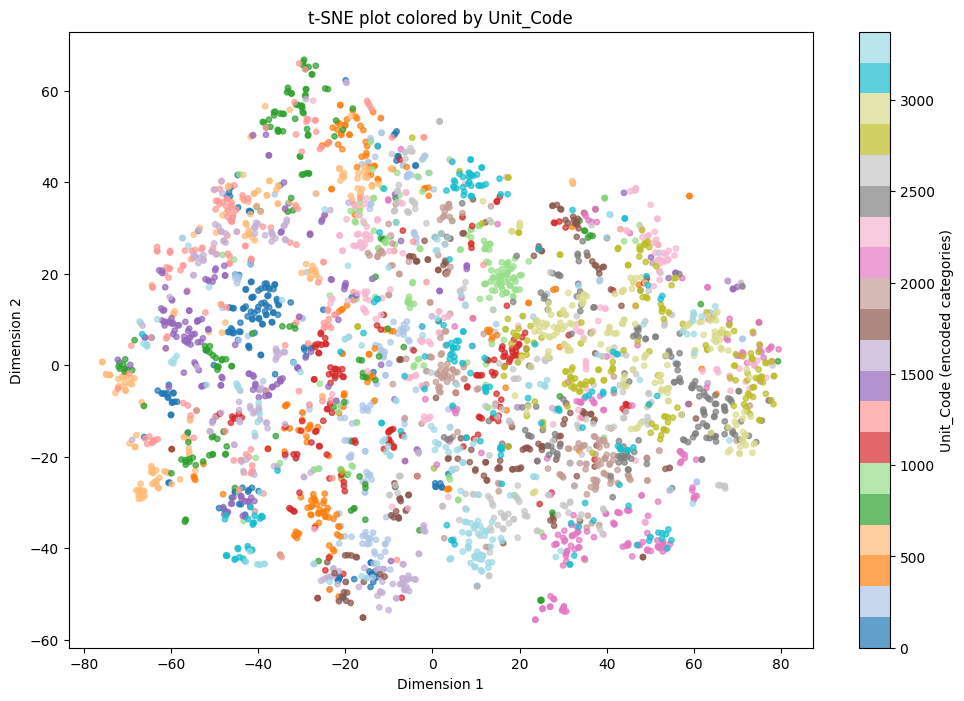

In [11]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Assuming embeddings are loaded and tsne applied:
embeddings = np.load('embeddings/nco_embeddings.npy')
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

# Use your actual unit code column as labels
labels = df['Unit_Code']

plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels.astype('category').cat.codes, cmap='tab20', s=15, alpha=0.7)
plt.colorbar(scatter, label='Unit_Code (encoded categories)')
plt.title('t-SNE plot colored by Unit_Code')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


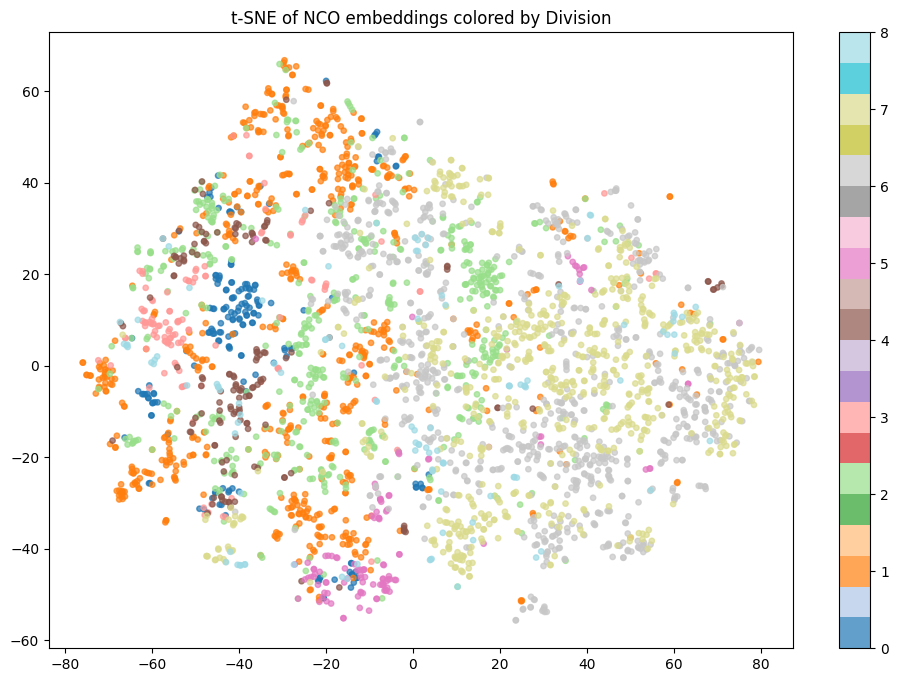

In [13]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

labels = df['Division'].astype('category').cat.codes
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap='tab20', s=15, alpha=0.7)
plt.colorbar(scatter, ticks=range(len(df['Division'].unique())))
plt.title('t-SNE of NCO embeddings colored by Division')
plt.show()


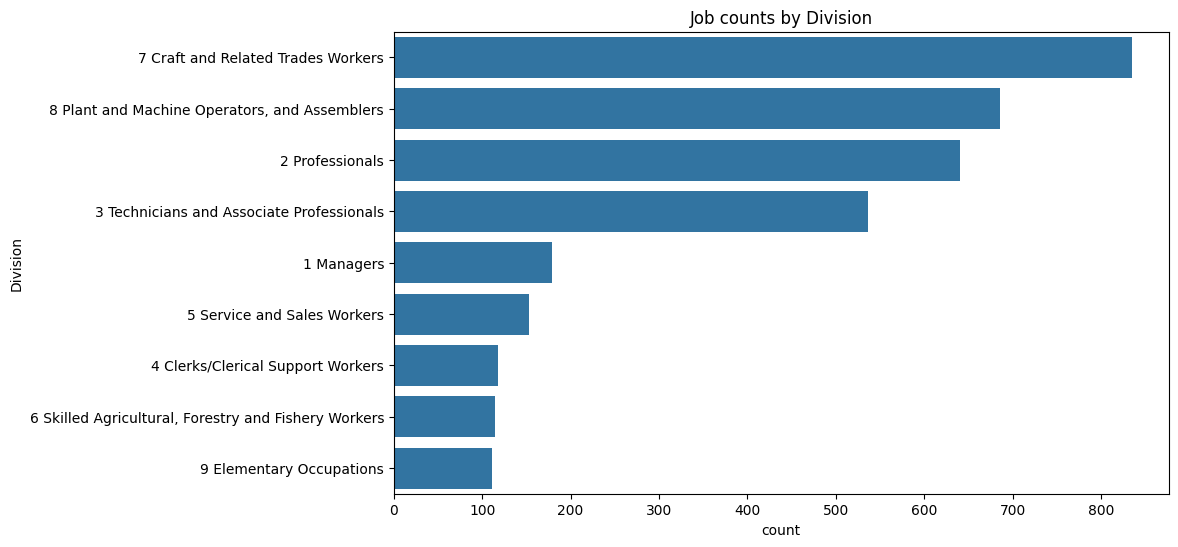

In [16]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.countplot(y='Division', data=df, order=df['Division'].value_counts().index)
plt.title('Job counts by Division')
plt.show()


In [30]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display

# Load data
df = pd.read_csv('/home/harikrishnan/Statathon/nco-semantic-search/data/processed/nco_cleaned.csv')


# Initialize model
model = SentenceTransformer('all-MiniLM-L6-v2')
# You should update this with your own test queries & expected correct matches
test_queries = [
    {"query": "electrician", "expected_unit_title": "Electrical Engineering Technicians"},
    {"query": "electrical maintenance worker", "expected_unit_title": "Electrical Engineering Technicians"},
    {"query": "tailor", "expected_unit_title": "Sewing Machine Operators"},
    {"query": "chemical plant worker", "expected_unit_title": "Chemical Engineering Technicians"},
    {"query": "construction assistant", "expected_unit_title": "Civil Engineering Technicians"},
    {"query": "mechanic", "expected_unit_title": "Mechanical Engineering Technicians"},
    {"query": "miner", "expected_unit_title": "Mining and Metallurgical Technicians"},
    {"query": "coder", "expected_unit_title": "Software and Applications Developers and Analysts"},
    {"query": "typist", "expected_unit_title": "Data Entry Operators"},
    {"query": "pharmacy helper", "expected_unit_title": "Pharmacy Assistants"},
]
tougher_test_queries = [
    {"query": "software engineer", "expected_unit_title": "Software and Applications Developers and Analysts"},
    {"query": "field technician", "expected_unit_title": "Electrical Engineering Technicians"},  # or Mechanical Engineering Technicians depending on context
    {"query": "project manager", "expected_unit_title": "Construction Managers"},  # or IT Project Managers or Engineering Managers
    {"query": "quality control inspector", "expected_unit_title": "Quality Control Inspectors"},
    {"query": "medical assistant", "expected_unit_title": "Medical Assistants"},
    {"query": "network administrator", "expected_unit_title": "Network and Computer Systems Administrators"},
    {"query": "logistics coordinator", "expected_unit_title": "Logistics Coordinators"},
    {"query": "civil drafter", "expected_unit_title": "Civil Engineering Technicians"},
    {"query": "help desk support", "expected_unit_title": "Computer Support Specialists"},
    {"query": "pharmaceutical sales rep", "expected_unit_title": "Pharmaceutical Sales Representatives"},
]

# Embed queries
query_texts = [q["query"] for q in test_queries]
query_embeddings = model.encode(query_texts)
query_embeddings = query_embeddings / np.linalg.norm(query_embeddings, axis=1, keepdims=True)






In [25]:
import pandas as pd
import numpy as np
from IPython.display import display

def evaluate_multiple_variants_top5_only(embedding_variants, query_embeddings, df, test_queries, top_k=5):
    """
    embedding_variants: dict, e.g. {
        "Variant A": embeddings_a,
        "Variant B": embeddings_b,
        ...
    }
    query_embeddings: np.array of shape (num_queries, emb_dim)
    df: pandas DataFrame containing occupation data with 'Unit_Title'
    test_queries: list of dicts with keys 'query' and 'expected_unit_title'
    top_k: number of top results to show (default 5)
    """

    rows = []
    print("\nEvaluating multiple variants (showing only top-5 results):\n")

    for i, q_emb in enumerate(query_embeddings):
        query = test_queries[i]['query']
        expected = test_queries[i]['expected_unit_title']

        row = {
            "Query": query,
        }

        for variant_name, embeddings in embedding_variants.items():
            sims = np.dot(embeddings, q_emb)
            top_indices = np.argsort(sims)[::-1][:top_k]
            top_titles = df.iloc[top_indices]['Unit_Title'].values

            # Only one column per variant, showing top-k results separated by '||||'
            row[f"{variant_name} Top-{top_k}"] = "|||| ".join(top_titles)

        rows.append(row)

    results_df = pd.DataFrame(rows)

    # Pretty display in Jupyter
    display(results_df.style.set_properties(**{
        'text-align': 'left',
        'white-space': 'pre-wrap',
        'font-family': 'monospace',
        'font-size': '11pt',
    }).set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'left')]},
        {'selector': 'td', 'props': [('vertical-align', 'top')]}
    ]))

    return results_df


In [32]:
from transformers.utils import logging
import os

print(os.path.expanduser("~/.cache/huggingface/transformers"))


/home/harikrishnan/.cache/huggingface/transformers


In [20]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

# Load your data CSV (adjust path)
df = pd.read_csv("/home/harikrishnan/Statathon/nco-semantic-search/data/processed/nco_cleaned.csv")

# Load model once
model = SentenceTransformer('all-MiniLM-L6-v2')

# Define variant text generators, always including Unit_Description
def variant_a(row):
    # Unit_Title only (for reference, not recommended since you want Unit_Description in all)
    return f"{row['Unit_Title']}"

def variant_b(row):
    # Unit_Title + Unit_Description (baseline, performs well)
    return f"{row['Unit_Title']}. {row['Unit_Description']}"

def variant_d(row):
    # Family Description + Unit_Title + Unit_Description
    return f"{row['Family_Description']}. {row['Unit_Title']}. {row['Unit_Description']}"

def variant_e(row):
    # Group Description + Family Description + Unit_Title + Unit_Description
    return f"{row['Group_Description']}. {row['Family_Description']}. {row['Unit_Title']}. {row['Unit_Description']}"

def variant_f(row):
    # Sub Division Description + Group Description + Family Description + Unit_Title + Unit_Description
    return (
        f"{row['Sub_Division_Description']}. {row['Group_Description']}. "
        f"{row['Family_Description']}. {row['Unit_Title']}. {row['Unit_Description']}"
    )

def variant_g(row):
    # Division Description + Sub Division Description + Group Description + Family Description + Unit_Title + Unit_Description
    return (
        f"{row['Division_Description']}. {row['Sub_Division_Description']}. "
        f"{row['Group_Description']}. {row['Family_Description']}. "
        f"{row['Unit_Title']}. {row['Unit_Description']}"
    )

# Map variant names to functions
variant_functions = {
    "Variant A": variant_a,
    "Variant B": variant_b,
    "Variant D": variant_d,
    "Variant E": variant_e,
    "Variant F": variant_f,
    "Variant G": variant_g,
}

# Prepare storage for embeddings
embedding_variants = {}

# Generate embeddings for each variant
for variant_name, text_func in variant_functions.items():
    print(f"Processing {variant_name} embeddings...")
    # Create text list for all rows
    texts = []
    for idx, row in df.iterrows():
        # Handle missing data gracefully by filling with empty strings
        text = text_func(row.fillna(''))
        texts.append(text)
    
    # Embed in batches for efficiency
    embeddings = model.encode(texts, batch_size=64, show_progress_bar=True, normalize_embeddings=True)
    embeddings = np.array(embeddings)
    
    embedding_variants[variant_name] = embeddings

print("All embeddings generated and stored in embedding_variants dictionary.")


Processing Variant A embeddings...


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Processing Variant B embeddings...


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Processing Variant D embeddings...


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Processing Variant E embeddings...


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Processing Variant F embeddings...


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Processing Variant G embeddings...


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

All embeddings generated and stored in embedding_variants dictionary.


In [28]:
first_3_items = dict(list(embedding_variants.items())[:3])


In [31]:


evaluate_multiple_variants_top5_only(first_3_items, query_embeddings, df, test_queries, top_k=5)



Evaluating multiple variants (showing only top-5 results):



Query  \
0          software engineer   
1           field technician   
2            project manager   
3  quality control inspector   
4          medical assistant   
5      network administrator   
6      logistics coordinator   
7              civil drafter   
8          help desk support   
9   pharmaceutical sales rep   

                                     Variant A Top-5  \
0  Software Engineer|||| Computer Programmer/Soft...   
1  Field Technician (Computing and Peripherals)||...   
2  Manager, Construction/Manager Construction Pro...   
3  Quality Control Inspector-Visual Inspection|||...   
4  Medical Assistants, Other|||| Pharmacy Assista...   
5  Data Communication Analyst/Network Administrat...   
6  Warehouse Supervisor|||| Home Delivery Manager...   
7  Draftsman|||| Plumbing Draftsman|||| Picker|||...   
8  Support Engineer|||| Remote Helpdesk Technicia...   
9  Pharmaceutical Assistants, Other|||| Pharmacis...   

                                     Variant B Top-5  \
0  Embedded Software Engineer|||| Software Develo...   
1  Field Technician (Computing and Peripherals)||...   
2  Manager, Construction/Manager Construction Pro...   
3  Quality Control Inspector-Statistical process ...   
4  Medical Assistants, Other|||| Pharmaceutical A...   
5  System Administration Assistant/Junior System ...   
6  Warehouse Supervisor|||| Inventory Clerk|||| S...   
7  Draftsman|||| Plumbing Draftsman|||| Warehouse...   
8  Domestic IT Helpdesk Attendant|||| Remote Help...   
9  Medical Representative|||| Pharmaceutical Assi...   

                                     Variant D Top-5  
0  Engineer Trainee-IT Services|||| Engineer Trai...  
1  Field Technician (Computing and Peripherals)||...  
2  Manager, Construction/Manager Construction Pro...  
3  Quality Control Inspector-Statistical process ...  
4  Medical Assistants, Other|||| Refractionist|||...  
5  System Administration Assistant/Junior System ...  
6  Warehouse Worker|||| Warehouse Supervisor|||| ...  
7  Draftsman|||| Plumbing Draftsman|||| Warehouse...  
8  Domestic IT Helpdesk Attendant|||| Information...  
9  Chemist, Pharmaceuticals|||| Medical Represent...

In [ ]:
import pandas as pd

# Load the CSV
df = pd.read_csv("/home/harikrishnan/Statathon/nco-semantic-search/data/processed/nco_hierarchy_with_2004.csv")

# Split 'Division' into numeric code and title
df[['Division_Code', 'Division_Title']] = df['Division'].str.extract(r'(\d+)\s+(.*)')

# Normalize
df['Division_Code'] = df['Division_Code'].astype(str).str.strip()
df['Division_Title'] = df['Division_Title'].str.strip().str.lower()

# Count rows where Division is '1 Managers'
count = df[(df['Division_Code'] == '4') ].shape[0]

print(f"✅ Number of rows for Division '1 Managers': {count}")


✅ Number of rows for Division '1 Managers': 118


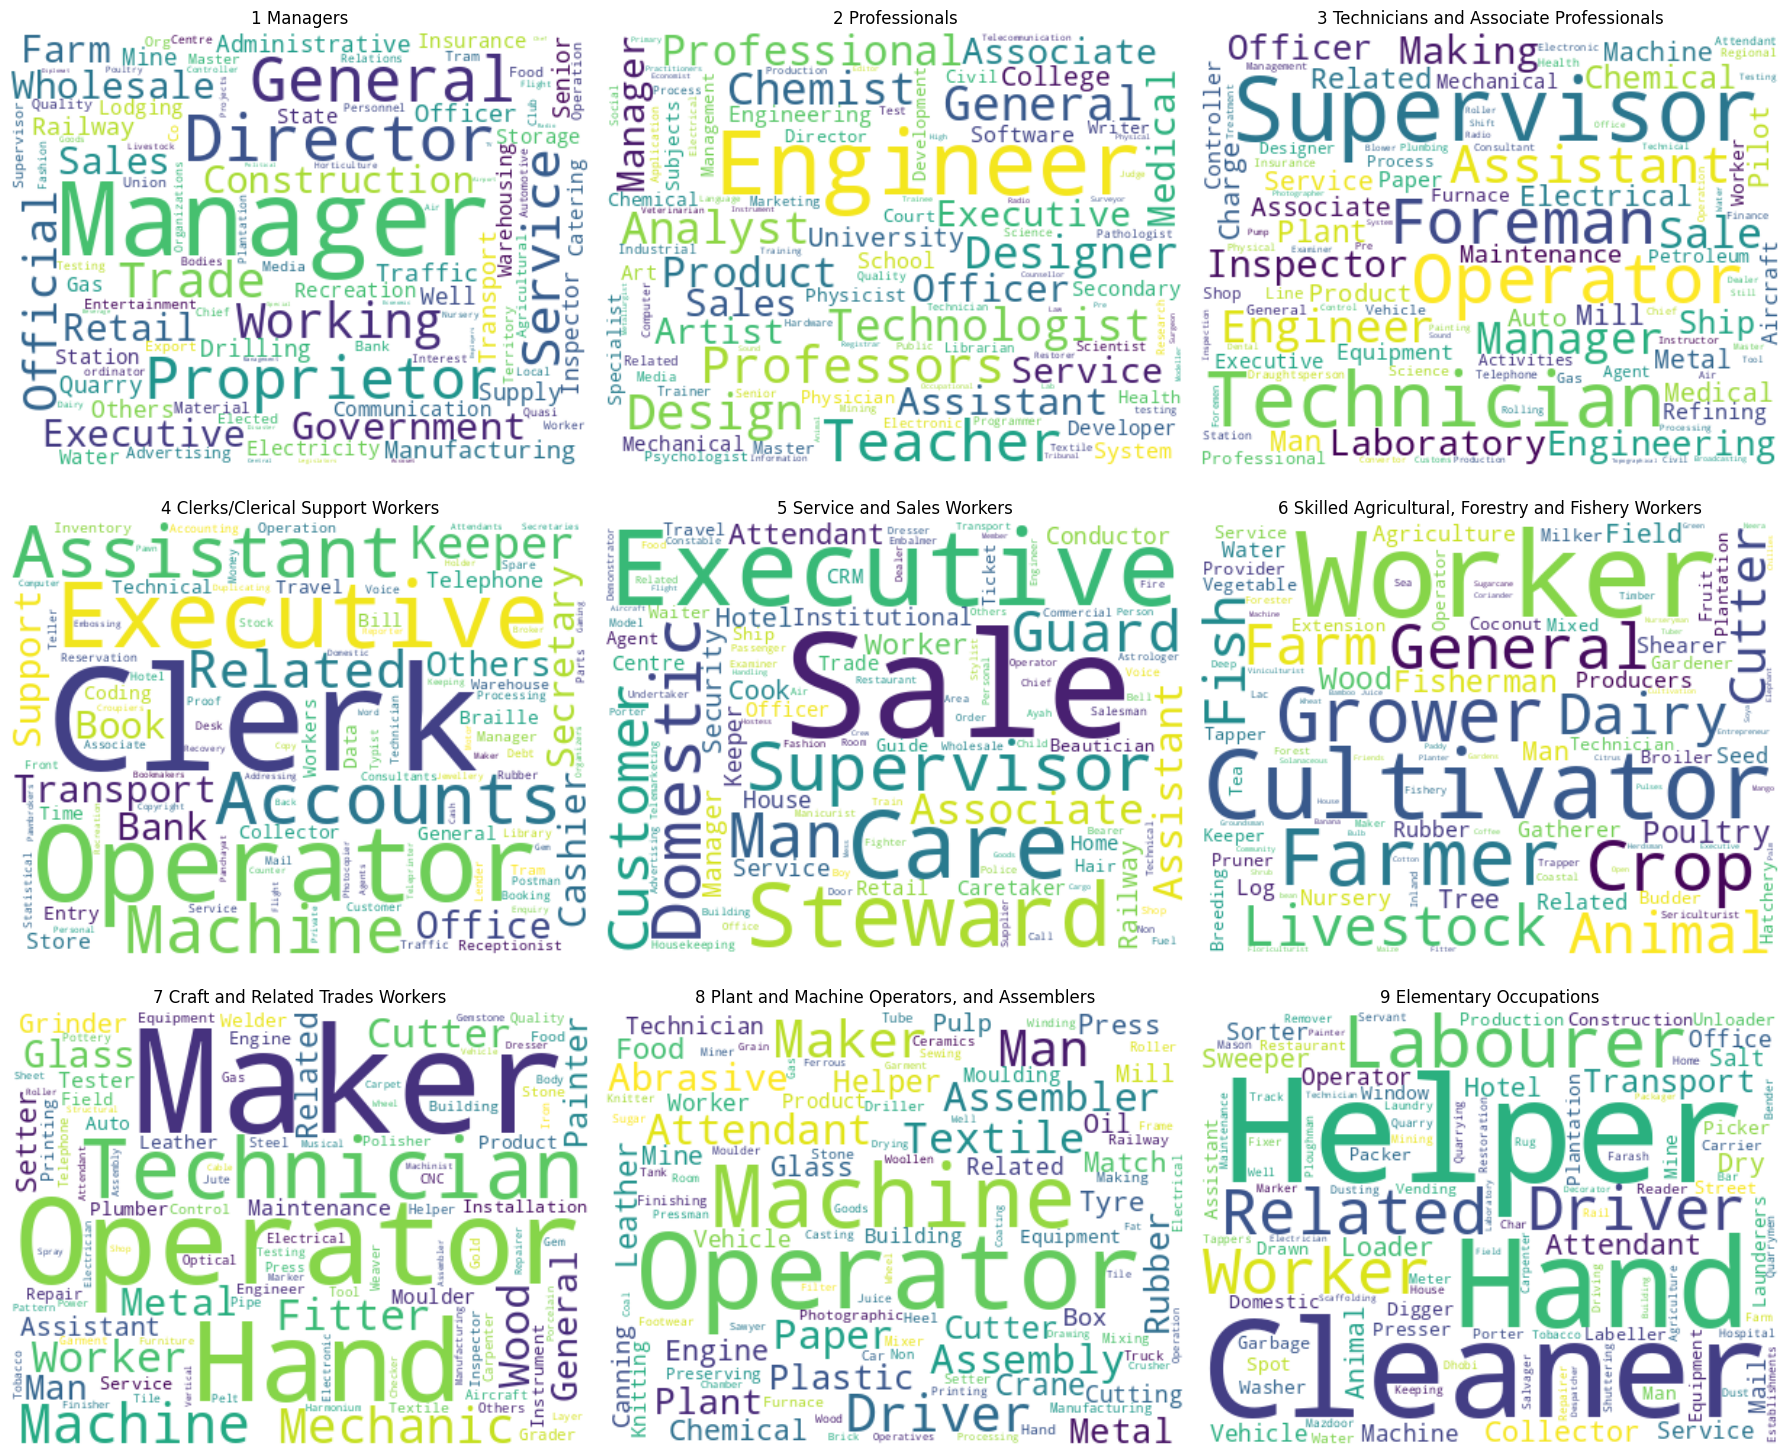

In [20]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

# If you haven't installed wordcloud yet, run:
# !pip install wordcloud

# Combine Unit_Title and Unit_Description for richer text
df['text_combined'] = df['Unit_Title'] 

# Get unique divisions
divisions = df['Division'].unique()

# Plot wordclouds, one per division (adjust grid size as needed)
n_divisions = len(divisions)
cols = 3
rows = (n_divisions + cols - 1) // cols

plt.figure(figsize=(cols * 6, rows * 5))

for i, division in enumerate(divisions):
    plt.subplot(rows, cols, i + 1)
    text = ' '.join(df.loc[df['Division'] == division, 'text_combined'].dropna().tolist())
    if len(text.strip()) == 0:
        plt.title(f"{division}\n(No text)")
        plt.axis('off')
        continue

    wordcloud = WordCloud(width=400, height=300, background_color='white', max_words=100,
                          collocations=False).generate(text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(division)
    plt.axis('off')

plt.tight_layout()
plt.show()


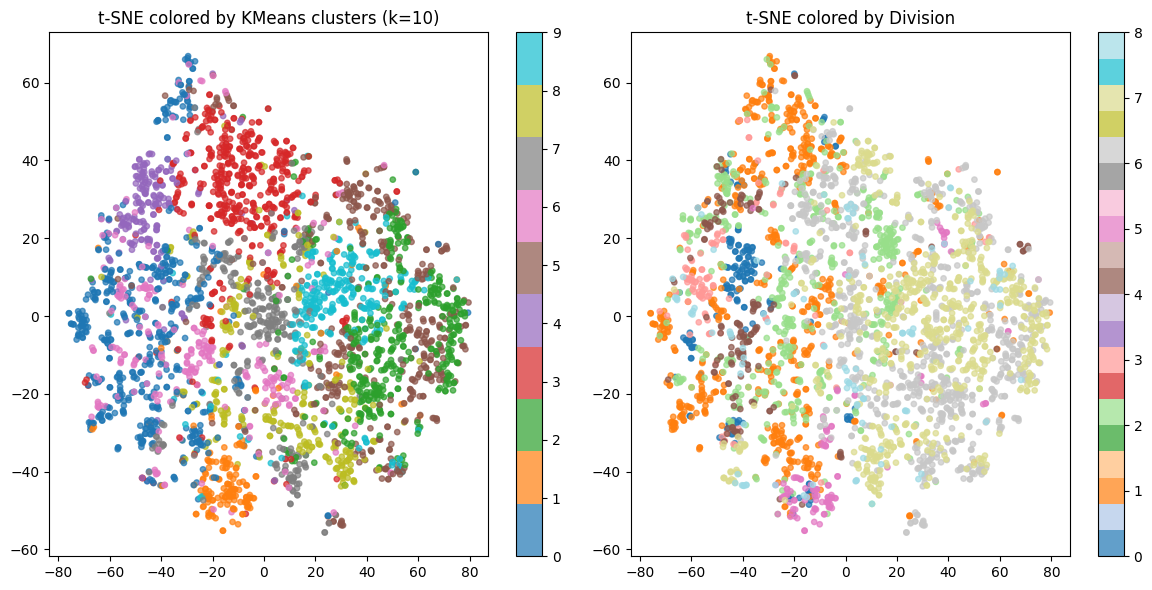

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Assume embeddings and df are loaded

# 1. Cluster with KMeans
n_clusters = 10  # tune this based on your data or use methods like elbow method
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# 2. Dimensionality reduction with t-SNE (or use UMAP if you prefer)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

# 3. Plot clusters
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='tab10', s=15, alpha=0.7)
plt.colorbar(scatter)
plt.title(f't-SNE colored by KMeans clusters (k={n_clusters})')

# 4. Plot known categories (e.g., Division) for comparison
labels = df['Division'].astype('category').cat.codes
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab20', s=15, alpha=0.7)
plt.colorbar(scatter2)
plt.title('t-SNE colored by Division')

plt.tight_layout()
plt.show()


/home/harikrishnan/venvs/statathon_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_226915/3782291176.py:9: UserWarning: The palette list has more values (120) than needed (119), which may not be intended.
  sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=labels, legend='full', palette=palette, s=15, alpha=0.7)
/tmp/ipykernel_226915/3782291176.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


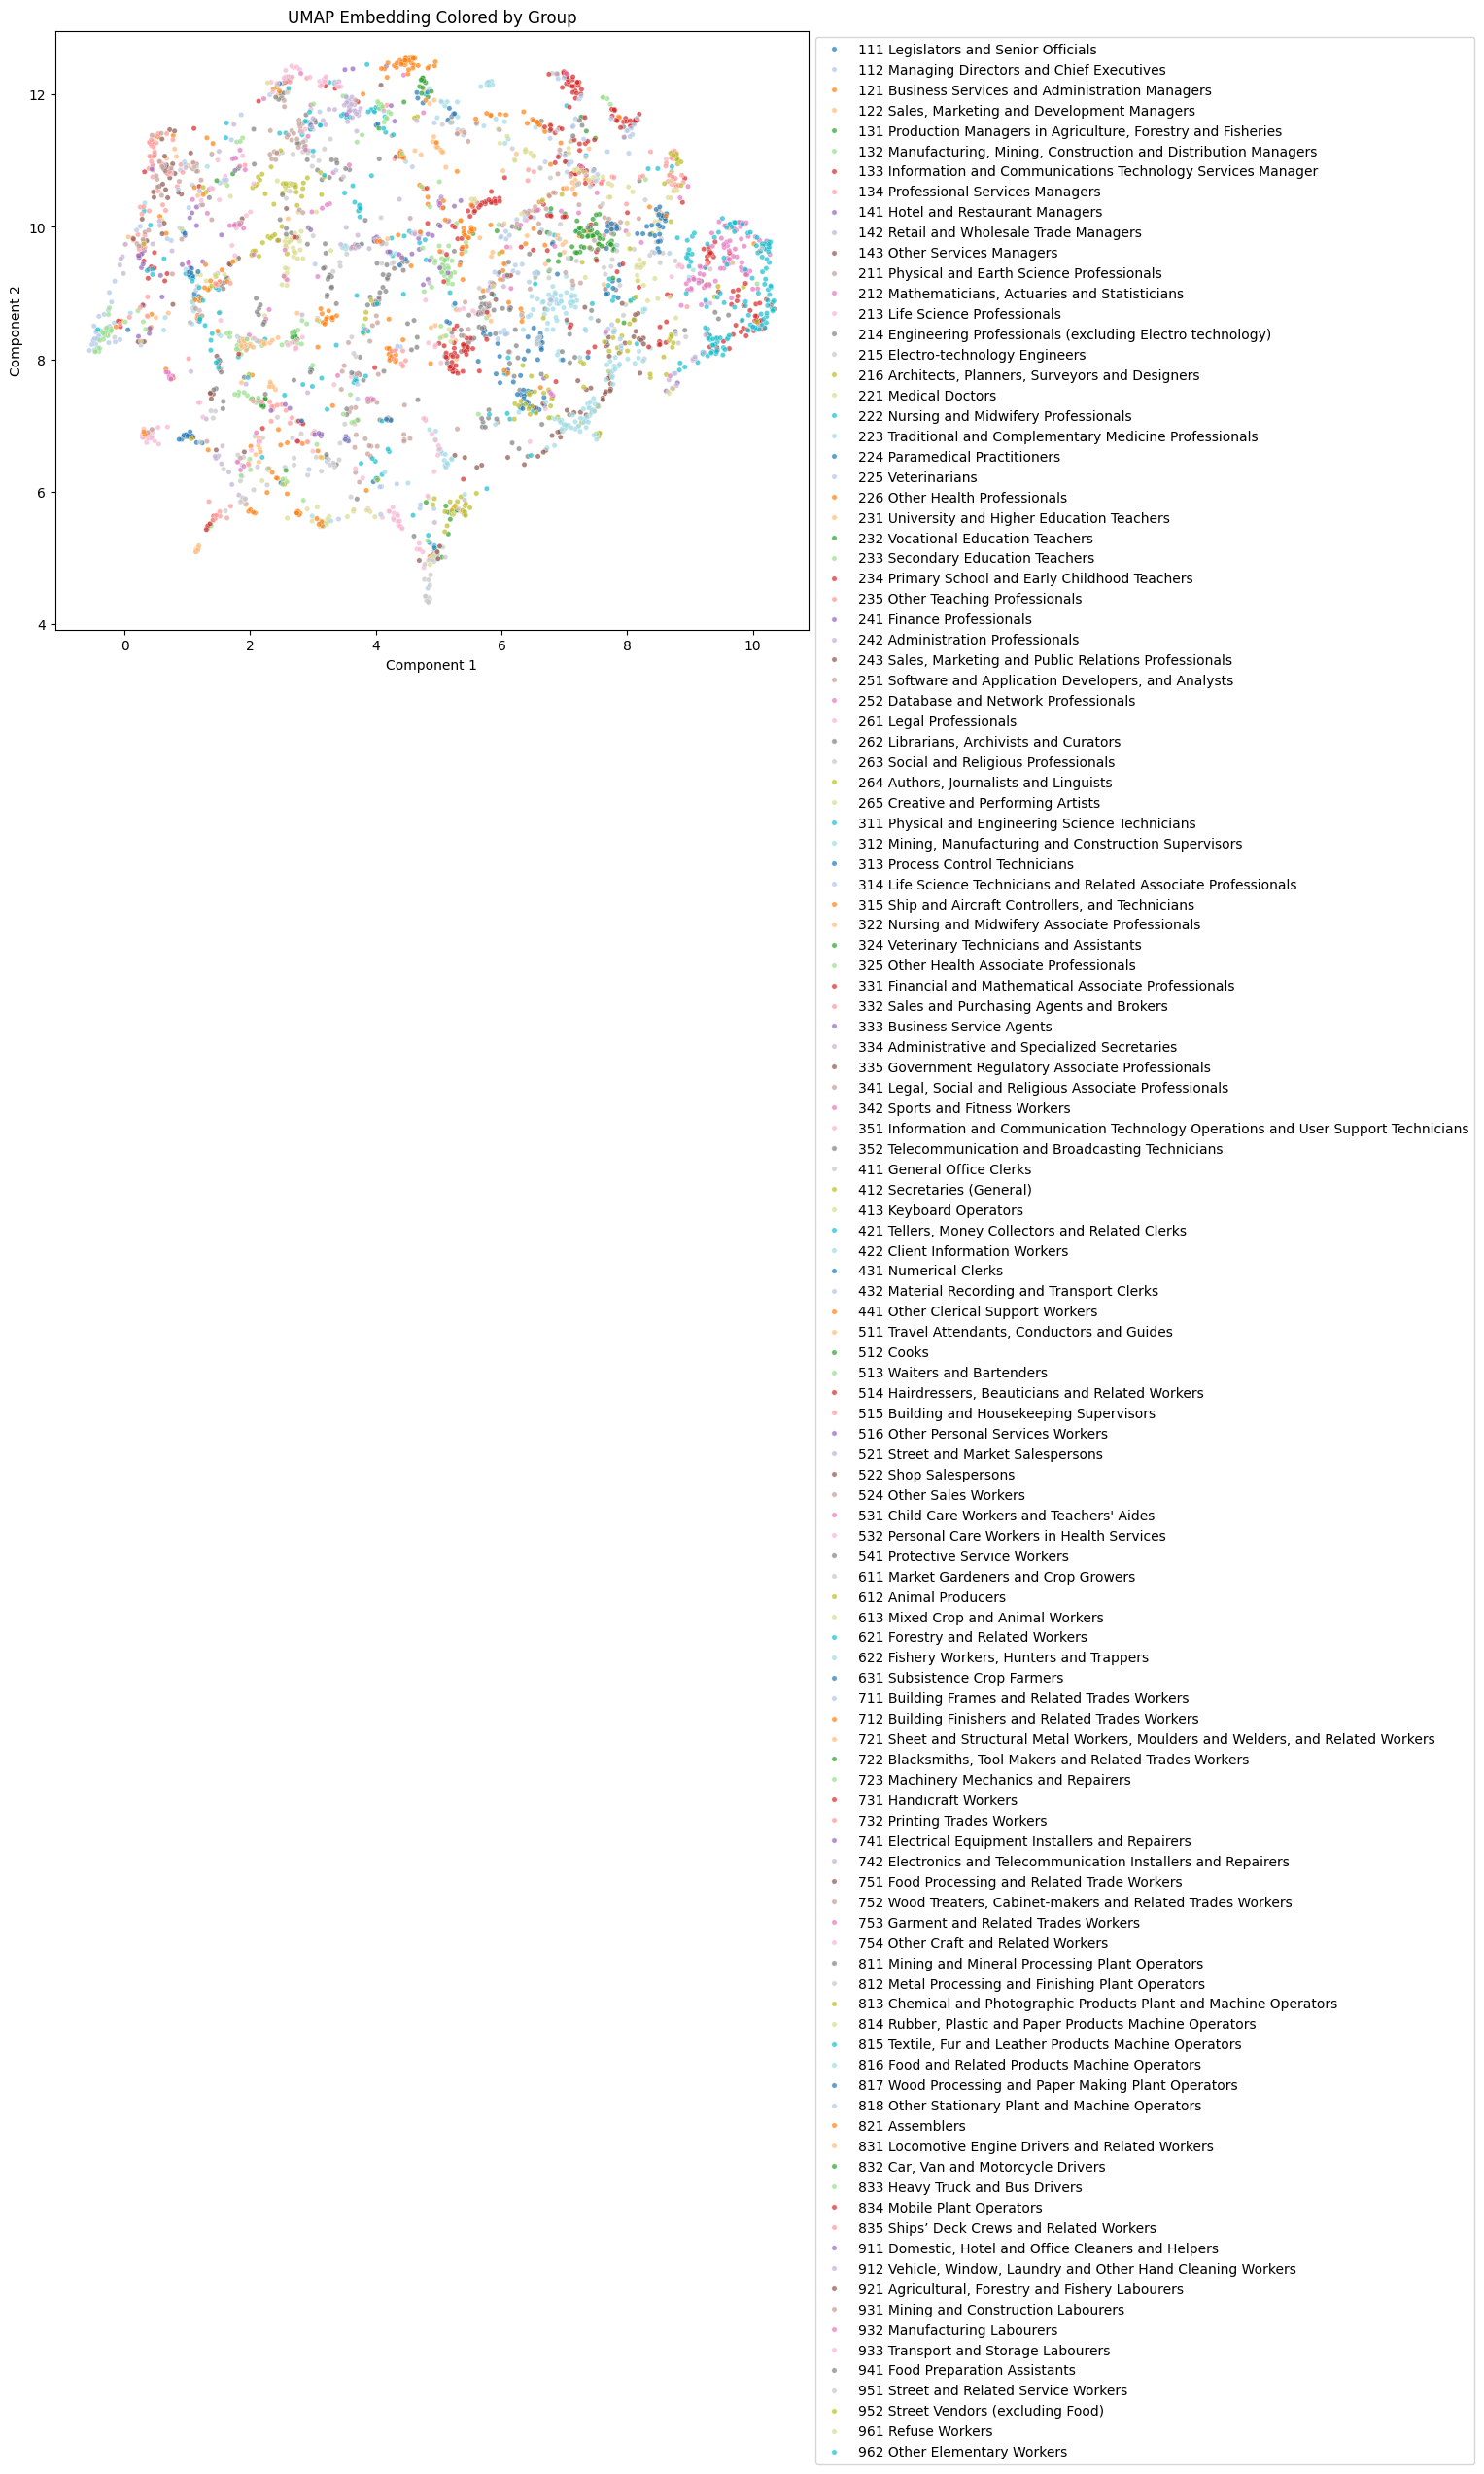

In [32]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap.umap_ as umap
import seaborn as sns

def plot_embedding_2d(embeddings, labels, title):
    plt.figure(figsize=(10,8))
    palette = sns.color_palette("tab20", len(set(labels)))
    sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=labels, legend='full', palette=palette, s=15, alpha=0.7)
    plt.title(title)
    plt.legend(loc='best', bbox_to_anchor=(1, 1))
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.tight_layout()
    plt.show()

# t-SNE (slow, try smaller subset if large)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_tsne = tsne.fit_transform(embeddings)

# UMAP (faster, preserves global structure)
reducer = umap.UMAP(n_components=2, random_state=42)
emb_umap = reducer.fit_transform(embeddings)

# Plot colored by Division


# Repeat for Group or Unit_Code as labels
plot_embedding_2d(emb_umap, df['Group'], "UMAP Embedding Colored by Group")


In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import numpy as np

# Cluster (choose k as you want or use elbow method)
k = 20
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Add cluster info to df
df['cluster'] = clusters

# Confusion matrix between clusters and Divisions
cm = confusion_matrix(df['Division'].astype('category').cat.codes, clusters)
cm_df = pd.DataFrame(cm,
                     index=df['Division'].astype('category').cat.categories,
                     columns=[f'Cluster {i}' for i in range(k)])

plt.figure(figsize=(12,8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix: Division vs Clusters")
plt.ylabel("Division")
plt.xlabel("Cluster")
plt.show()


ValueError: Shape of passed values is (20, 20), indices imply (9, 20)

In [34]:
from sklearn.neighbors import NearestNeighbors

# Fit NearestNeighbors on embeddings
nbrs = NearestNeighbors(n_neighbors=6, metric='cosine').fit(embeddings)

def print_nearest_jobs(index, top_k=5):
    distances, indices = nbrs.kneighbors(embeddings[index].reshape(1, -1), n_neighbors=top_k+1)
    print(f"Nearest jobs to:\n{df.iloc[index]['Unit_Title']}\n")
    for i, idx in enumerate(indices.flatten()[1:]):  # exclude itself
        print(f"{i+1}. {df.iloc[idx]['Unit_Title']} (Distance: {distances.flatten()[i+1]:.3f})")

# Example
print_nearest_jobs(100)  # Change index to any job


Nearest jobs to:
Manager, Aerial Planting and Cultivation

1. General Manager, Agricultural Farm (Distance: 0.329)
2. Manager, Agricultural Farm (Distance: 0.334)
3. Seed Grower/Quality Seed Grower (Distance: 0.349)
4. Farm Overseer, Crop Production (Distance: 0.374)
5. Manager, Nursery (Distance: 0.379)


In [38]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# Load your model once
model = SentenceTransformer('all-MiniLM-L6-v2')

# Assuming df and embeddings are loaded and aligned
# df should have columns: ['Unit_Code', 'Unit_Title', 'Unit_Description']

def semantic_search(query, df, embeddings, top_n=5):
    # 1. Encode query
    query_emb = model.encode([query])

    # 2. Compute cosine similarity with all dataset embeddings
    sims = cosine_similarity(query_emb, embeddings)[0]

    # 3. Get indices of top_n highest scores
    top_indices = np.argsort(sims)[::-1][:top_n]

    # 4. Prepare results
    results = []
    for idx in top_indices:
        results.append({
            'Unit_Code': df.iloc[idx]['Unit_Code'],
            'Unit_Title': df.iloc[idx]['Unit_Title'],
            'Unit_Description': df.iloc[idx]['Unit_Description'],
            'Confidence_Score': sims[idx]
        })
    return pd.DataFrame(results)

# Example usage:
query = "sewing operator"
results_df = semantic_search(query, df, embeddings, top_n=5)
print(results_df)


   Unit_Code                                     Unit_Title  \
0  8153.0103            Specialized Sewing Machine Operator   
1  8153.0101               Sewing Machine Operator, General   
2  8153.0601  Embroidery Machine Operator (Zig Zag Machine)   
3  8156.1500                         Sole Stitcher, Machine   
4  8159.0400                                 Press Operator   

                                    Unit_Description  Confidence_Score  
0  Specialized Sewing Machine Operator is respons...          0.772448  
1  Sewing Machine Operator, General; Stitcher Mac...          0.700325  
2  Embroidery Machine Operator is responsible for...          0.651190  
3  Sole Stitcher, Machine; Sole Stitching Machine...          0.615494  
4  Press Operator tends machine that steams and p...          0.606289  


In [3]:
import os
import numpy as np
import faiss

def build_faiss_index(embeddings_path: str, index_path: str) -> None:
    """
    Builds and saves a FAISS index from precomputed embeddings.
    Args:
        embeddings_path (str): Path to the .npy file containing embeddings.
        index_path (str): Path to save the FAISS index.
    """
    if not os.path.exists(embeddings_path):
        raise FileNotFoundError(f"Embeddings not found at {embeddings_path}")
    
    print(f"[Index] Loading embeddings from {embeddings_path} ...")
    embeddings = np.load(embeddings_path).astype('float32')
    dim = embeddings.shape[1]
    print(f"[Index] Embeddings shape: {embeddings.shape}")

    # Build index (exact nearest neighbors with L2 metric)
    index = faiss.IndexFlatL2(dim)
    print("[Index] Adding vectors to the index ...")
    index.add(embeddings)

    # Save index
    os.makedirs(os.path.dirname(index_path), exist_ok=True)
    faiss.write_index(index, index_path)
    print(f"[Index] Index saved to {index_path}")

build_faiss_index("embeddings/nco_embeddings.npy", "embeddings/nco_index.faiss")


[Index] Loading embeddings from embeddings/nco_embeddings.npy ...
[Index] Embeddings shape: (3375, 384)
[Index] Adding vectors to the index ...
[Index] Index saved to embeddings/nco_index.faiss


Loaded FAISS index from embeddings/nco_index.faiss
Running UMAP dimensionality reduction...


/home/harikrishnan/venvs/statathon_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/harikrishnan/venvs/statathon_env/lib/python3.12/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


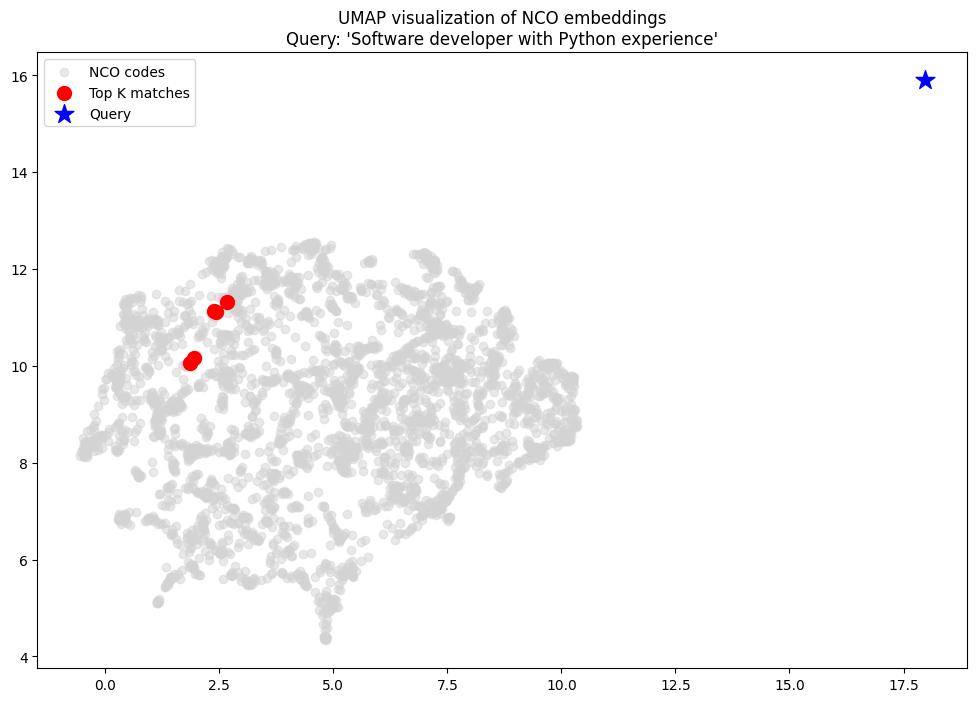


Top K matches:
1. NCO_622 (distance=1.0922)
2. NCO_617 (distance=1.1512)
3. NCO_1319 (distance=1.1854)
4. NCO_627 (distance=1.2016)
5. NCO_624 (distance=1.2300)


In [4]:
import os
import numpy as np
import faiss
import matplotlib.pyplot as plt
import umap
from sentence_transformers import SentenceTransformer

# Load embeddings and labels
embeddings_path = "embeddings/nco_embeddings.npy"
index_path = "embeddings/nco_index.faiss"

if not os.path.exists(embeddings_path):
    raise FileNotFoundError(f"Embeddings not found at {embeddings_path}")
embeddings = np.load(embeddings_path).astype('float32')

# Mock labels for NCO codes (replace with your actual labels)
nco_labels = [f"NCO_{i}" for i in range(embeddings.shape[0])]

# Load or build FAISS index
if os.path.exists(index_path):
    index = faiss.read_index(index_path)
    print(f"Loaded FAISS index from {index_path}")
else:
    dim = embeddings.shape[1]
    index = faiss.IndexFlatL2(dim)
    index.add(embeddings)
    os.makedirs(os.path.dirname(index_path), exist_ok=True)
    faiss.write_index(index, index_path)
    print(f"Built and saved FAISS index to {index_path}")

# Dimensionality reduction with UMAP
print("Running UMAP dimensionality reduction...")
reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = reducer.fit_transform(embeddings)

# Load sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Query example
query_text = "Software developer with Python experience"
query_embedding = model.encode([query_text]).astype('float32')

# Search top K neighbors
K = 5
distances, indices = index.search(query_embedding, K)

# Project query embedding with UMAP (approximate: fit_transform on combined top-K + query)
combined = np.vstack([embeddings[indices[0]], query_embedding])
combined_2d = reducer.fit_transform(combined)

query_2d = combined_2d[-1]  # last is query
matches_2d = combined_2d[:-1]

# Plot embeddings and highlight top K matches + query
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color='lightgray', alpha=0.5, label='NCO codes')
plt.scatter(embeddings_2d[indices[0], 0], embeddings_2d[indices[0], 1], color='red', label='Top K matches', s=100)
plt.scatter(query_2d[0], query_2d[1], color='blue', marker='*', s=200, label='Query')

plt.title(f"UMAP visualization of NCO embeddings\nQuery: '{query_text}'")
plt.legend()
plt.show()

# Print retrieved matches with distances
print("\nTop K matches:")
for rank, (idx, dist) in enumerate(zip(indices[0], distances[0]), 1):
    print(f"{rank}. {nco_labels[idx]} (distance={dist:.4f})")


In [7]:
import pandas as pd
top_indices = [622, 617, 1319, 627, 624]  # example output from faiss search
top_distances = [1.0922, 1.1512, 1.1854, 1.2016, 1.2300]
df = pd.read_csv('data/processed/hierarchy_with_qps_clean.csv')

def distance_to_confidence(distances, max_dist=3.0):
    confidences = 1 - (np.array(distances) / max_dist)
    return np.clip(confidences, 0, 1)

confidences = distance_to_confidence(top_distances)

for rank, (idx, dist, conf) in enumerate(zip(top_indices, top_distances, confidences), 1):
    unit_title = df.loc[idx, 'Unit_Title']
    unit_desc = df.loc[idx, 'Unit_Description']
    
    print(f"{rank}. {unit_title}")
    print(f"   Description: {unit_desc}")
    print(f"   Confidence Score: {conf:.2f}, Distance: {dist:.4f}\n")


1. Software Developer-Product Development and Delivery
   Description: Software Developer is responsible for using specialized knowledge of software programming languages, software integration and delivery platforms to build software products and deliver business solutions. The job also involves application enhancement, debugging, maintenance and documentation. Qualification Pack Details: QP NOS Reference SSC/Q6702 QP NOS Name Software Developer NSQF Level 7
   Confidence Score: 0.64, Distance: 1.0922

2. Software Developer-Application Development
   Description: Software Developer is responsible for development of software applications and interfaces as well as enhancements to existing packaged applications or pre- engineered templates. The job also involves providing support to custom applications, debugging, maintenance and documentation. Qualification Pack Details: QP NOS Reference SSC/Q0501 QP NOS Name Software Developer- Application Development NSQF Level 7
   Confidence Score: 0

In [24]:
import pandas as pd

# Load the CSV
df = pd.read_csv("/home/harikrishnan/Statathon/nco-semantic-search/data/processed/nco_hierarchy_with_2004.csv")

# Split 'Division' into numeric code and title
df[['Division_Code', 'Division_Title']] = df['Division'].str.extract(r'(\d+)\s+(.*)')

# Normalize
df['Division_Code'] = df['Division_Code'].astype(str).str.strip()
df['Division_Title'] = df['Division_Title'].str.strip().str.lower()

# Count rows where Division is '1 Managers'
count = df[(df['Division_Code'] == '4') ].shape[0]

print(f"✅ Number of rows for Division '1 Managers': {count}")


✅ Number of rows for Division '1 Managers': 118


In [10]:
import pandas as pd
from nltk.corpus import wordnet
csv_path = "/home/harikrishnan/Statathon/nco-semantic-search/data/processed/nco_cleaned.csv"
df = pd.read_csv(csv_path)

# Create a dictionary to hold synonyms per Unit_Title
synonym_corpus = {"en": []}
def get_synonyms(word, max_syns=3):
    """Get up to max_syns synonyms from WordNet for a single word."""
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name().replace("_", " "))
    # Limit to top `max_syns` to avoid combinatorial explosion
    return list(synonyms)[:max_syns] if synonyms else []

flat_synonyms_by_title = {}  # dict: Unit_Title -> list of synonyms

for title in df["Unit_Title"].dropna().unique():
    words = title.split()
    title_syns = set()
    for word in words:
        word_syns = get_synonyms(word)
        title_syns.update(word_syns)
    # Include the original title itself
    title_syns.add(title)
    flat_synonyms_by_title[title] = list(title_syns)

# Example: show 5 random titles and their synonyms
import random
sample_titles = random.sample(list(flat_synonyms_by_title.keys()), 5)
for t in sample_titles:
    print(f"Title: {t}")
    print(f"Synonyms: {flat_synonyms_by_title[t]}")
    print("-" * 50)


Title: Crane Operator, Pneumatic
Synonyms: ['Grus', 'crane', 'pneumatic', 'stretch out', 'Crane Operator, Pneumatic']
--------------------------------------------------
Title: Mixer Man
Synonyms: ['mixer', 'sociable', 'Mixer Man', 'world', 'Isle of Man', 'human beings', 'social']
--------------------------------------------------
Title: Manager, Material Control/Manager Materials
Synonyms: ['Manager, Material Control/Manager Materials', 'corporeal', 'material', 'stuff', 'textile']
--------------------------------------------------
Title: Gem Grinder, Machine
Synonyms: ['Gem Grinder, Machine', 'motorcar', 'stone', 'precious stone', 'automobile', 'auto', 'treasure']
--------------------------------------------------
Title: Grader and Matcher, Fur
Synonyms: ['Grader and Matcher, Fur', 'grader', 'fur', 'pelt']
--------------------------------------------------


In [12]:
import json
import os


# Map of titles to language
lang_by_title = {
    'Elected Official, Union Government': 'en',
    'Elected Official, State Government': 'en'
}

# Initialize dictionary
synonyms_by_lang = {}

for title, synonyms in flat_synonyms_by_title.items():
    lang = lang_by_title.get(title, 'en')  # default to 'en' if not specified
    if lang not in synonyms_by_lang:
        synonyms_by_lang[lang] = []
    synonyms_by_lang[lang].append(synonyms)  # include the title itself

# Save to JSON
output_path = "/home/harikrishnan/Statathon/nco-semantic-search/data/processed/synonyms.json"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(synonyms_by_lang, f, ensure_ascii=False, indent=2)

print(f"Saved synonyms by language to {output_path}")


Saved synonyms by language to /home/harikrishnan/Statathon/nco-semantic-search/data/processed/synonyms.json


In [8]:
flat_synonyms_by_title

{'Elected Official, Union Government': ['sexual union',
  'government activity',
  'regime',
  'elected',
  'elective',
  'spousal relationship',
  'labor union',
  'elect',
  'Elected Official, Union Government',
  'government'],
 'Elected Official, State Government': ['body politic',
  'government activity',
  'country',
  'elected',
  'elective',
  'regime',
  'Elected Official, State Government',
  'res publica',
  'elect',
  'government'],
 'Elected Official, Local Bodies': ['dead body',
  'local anesthetic',
  'topical anaesthetic',
  'torso',
  'elected',
  'elective',
  'consistency',
  'local',
  'elect',
  'Elected Official, Local Bodies'],
 'Legislators, Other': ['other', 'early', 'former', 'Legislators, Other'],
 'Administrative Official, Union Government': ['sexual union',
  'government activity',
  'regime',
  'administrative',
  'spousal relationship',
  'labor union',
  'Administrative Official, Union Government',
  'government'],
 'Diplomat': ['diplomat', 'diplomatist'

In [1]:
import os
os.chdir("/home/harikrishnan/Statathon/nco-semantic-search")


In [2]:
from scripts.search import NCOSearcher


In [3]:
searcher = NCOSearcher(
    model_name="lbs", 
    data_csv="data/processed/nco_cleaned.csv"
)

[Search] Loading SentenceTransformer model: sentence-transformers/LaBSE
[Search] Loading NCO data CSV...
[Search] Dataset loaded with 3384 entries.
[Search] Loading embeddings...
[Search] Loading FAISS index...

[Check] Verifying FAISS index ↔ DataFrame alignment...
[Warning] Index has 3376 vectors but DataFrame has 3384 rows!
         This usually means the CSV has changed but embeddings/index were not rebuilt.
[Search] Loaded synonym corpus from JSON
[Search] Loaded precomputed synonym embeddings
[Search] Synonym embeddings ready


In [8]:
query = "thisdoesnotexist"  # nonsense query to trigger fallback
results, fallback_suggestions = searcher.search(
    query, 
    top_k=5, 
    use_synonyms=False, 
    fallback_threshold=62  # adjust threshold here
)

print("Results:")
for r in results:
    print(r['Title'], r['Score'])

print("\nFallback suggestions:")
for f in fallback_suggestions:
    print(f)


[Search] Language = en
Results:
Mathematicians, Actuaries and Statisticians, Other 65.95777
Statistical, Mathematical and Related Associate Professionals, Other 65.121666
Medical and Health Technicians, Other 64.76156
Veterinary Technicians and Assistants, Other 64.3368
Dental Specialists, Other 63.98303

Fallback suggestions:


In [15]:
import pandas as pd

queries = [
    "Medical Technician",
    "Statistical Analysis",
    "Dentist",
    "Mathematics",
    "thisdoesnotexist",
    "asdf qwerty zxcv",
    "banana elephant quantum",
]

top_k = 5
threshold = 67  # the specific threshold to test
records = []

for query in queries:
    results, fallback_suggestions = searcher.search(
        query,
        top_k=top_k,
        use_synonyms=False,
        fallback_threshold=threshold
    )
    
    results_titles = [r["Title"] for r in results[:2]]  # Top 2 normal results
    fallback_titles = fallback_suggestions[:3]           # Top 2 fallback suggestions
    
    records.append({
        "query": query,
        "results_1": results_titles[0] if len(results_titles) > 0 else "",
        "results_2": results_titles[1] if len(results_titles) > 1 else "",
        "fallback_1": fallback_titles[0] if len(fallback_titles) > 0 else "",
        "fallback_2": fallback_titles[1] if len(fallback_titles) > 1 else "",
    })

df = pd.DataFrame(records)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
df


[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en


query  \
0       Medical Technician   
1     Statistical Analysis   
2                  Dentist   
3              Mathematics   
4         thisdoesnotexist   
5         asdf qwerty zxcv   
6  banana elephant quantum   

                                            results_1  \
0               Medical and Health Technicians, Other   
1  Mathematicians, Actuaries and Statisticians, Other   
2                           Dental Specialists, Other   
3  Mathematicians, Actuaries and Statisticians, Other   
4  Mathematicians, Actuaries and Statisticians, Other   
5                                          VFX Editor   
6                                       Banana Farmer   

                                                              results_2  \
0          Medical Imaging and Therapeutic Equipment Technicians, Other   
1                                                          Statistician   
2                                                        Prosthodontist   
3                                                         Mathematician   
4  Statistical, Mathematical and Related Associate Professionals, Other   
5                                                        Designer (CAD)   
6                                               Friends of Coconut Tree   

     fallback_1     fallback_2  
0                               
1                               
2                               
3                               
4       Dentist         Priest  
5  Shaft Worker   Blade Sawyer  
6      Banksman  Banana Farmer

In [11]:
print(df)

    threshold  \
0          62   
1          64   
2          66   
3          68   
4          70   
5          72   
6          74   
7          76   
8          78   
9          80   
10         82   
11         84   

                                                                                                                                                                                                                                       results  \
0   [Mathematicians, Actuaries and Statisticians, Other, Statistical, Mathematical and Related Associate Professionals, Other, Medical and Health Technicians, Other, Veterinary Technicians and Assistants, Other, Dental Specialists, Other]   
1   [Mathematicians, Actuaries and Statisticians, Other, Statistical, Mathematical and Related Associate Professionals, Other, Medical and Health Technicians, Other, Veterinary Technicians and Assistants, Other, Dental Specialists, Other]   
2   [Mathematicians, Actuaries and Statisticians, Ot

In [5]:
import numpy as np
import pandas as pd

# Example queries: mix of nonsense and real queries
queries = [
    "thisdoesnotexist", 
    "asdf qwerty zxcv", 
    "banana elephant quantum",
    "Statistical Analysis",  # sensible query
    "Medical Technician"
]

# Thresholds to test
thresholds = np.arange(40, 100, 5)  # 40, 45, 50 ... 95

# Store results
results_df = pd.DataFrame(columns=["query", "threshold", "results_count", "fallback_count"])

for query in queries:
    for thr in thresholds:
        results, fallback_suggestions = searcher.search(
            query, top_k=5, use_synonyms=False, fallback_threshold=thr
        )
        results_count = len(results)
        fallback_count = len(fallback_suggestions)
        results_df = pd.concat([results_df, pd.DataFrame([{
            "query": query,
            "threshold": thr,
            "results_count": results_count,
            "fallback_count": fallback_count
        }])], ignore_index=True)

# Show summary
print(results_df)

# Optional: find threshold where nonsense queries trigger fallback most reliably
nonsense_queries = ["thisdoesnotexist", "asdf qwerty zxcv", "banana elephant quantum"]
summary = results_df[results_df["query"].isin(nonsense_queries)].groupby("threshold")["fallback_count"].sum()
best_threshold = summary.idxmax()
print(f"\nRecommended fallback threshold: {best_threshold}")


[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] La

In [6]:
import numpy as np
import pandas as pd

# Define your queries
nonsense_queries = ["thisdoesnotexist", "asdf qwerty zxcv", "banana elephant quantum"]
sensible_queries = ["Statistical Analysis", "Medical Technician"]

# Thresholds to test
thresholds = np.arange(40, 100, 5)

# Store scores
scores = []

for thr in thresholds:
    # Track fallback counts
    nonsense_fallback = 0
    sensible_fallback = 0
    
    for query in nonsense_queries:
        _, fallback = searcher.search(query, top_k=5, use_synonyms=False, fallback_threshold=thr)
        nonsense_fallback += len(fallback)  # want this high
    
    for query in sensible_queries:
        _, fallback = searcher.search(query, top_k=5, use_synonyms=False, fallback_threshold=thr)
        sensible_fallback += len(fallback)  # want this low
    
    # Define a simple optimization score:
    # maximize nonsense fallback, minimize sensible fallback
    # Add 1 to avoid zero division
    opt_score = nonsense_fallback / (sensible_fallback + 1)
    
    scores.append({"threshold": thr, "nonsense_fallback": nonsense_fallback, 
                   "sensible_fallback": sensible_fallback, "opt_score": opt_score})

# Convert to DataFrame for easy analysis
score_df = pd.DataFrame(scores)
best_row = score_df.loc[score_df["opt_score"].idxmax()]

print("Threshold tuning results:")
print(score_df)

print(f"\nRecommended fallback threshold: {best_row['threshold']} "
      f"(Nonsense fallback={best_row['nonsense_fallback']}, Sensible fallback={best_row['sensible_fallback']})")


[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] Language = en
[Search] La

In [ ]:
# ===== Threshold tester with fallback visualization =====
import numpy as np
from tqdm import tqdm
import pandas as pd

# Example queries
sensible_queries = [
    "financial accounting basics",
    "introduction to machine learning",
    "human resource management"
]

nonsense_queries = [
    "asdf qwerty zxcv",
    "banana elephant quantum",
    "foobar lorem ipsum"
]

all_queries = sensible_queries + nonsense_queries

# Choose a searcher to test (e.g., LaBSE)

# Threshold candidates to evaluate
thresholds = np.arange(0.4, 0.8, 0.05)  # cosine similarity thresholds (0.4 to 0.75)

# Collect results including fallback suggestions
results_summary = []

for thr in tqdm(thresholds, desc="Testing thresholds"):
    for q in all_queries:
        res, fallback = searcher.search(q, top_k=5, use_synonyms=True, fallback_threshold=thr*100)
        results_summary.append({
            "query": q,
            "threshold": thr,
            "results_count": len(res),
            "fallback_suggestions": fallback
        })

df = pd.DataFrame(results_summary)

# Display only nonsense queries with their fallbacks
nonsense_df = df[df['query'].isin(nonsense_queries)].reset_index(drop=True)
print("Nonsense queries and their fallback suggestions:")
display(nonsense_df)


In [16]:
import gc
gc.collect()


0

In [4]:
import os
import pandas as pd
import random

# Folders to scan
folders_to_scan = [
    "app",
    "scripts",
    "scripts_bc",
    "backup_14_23_aug"
]

# File extensions to include
extensions = [".py", ".json", ".yaml"]

output_file = "all_project_code.txt"

with open(output_file, "w", encoding="utf-8") as out_f:
    # Merge scripts, JSON, YAML
    for folder in folders_to_scan:
        for root, dirs, files in os.walk(folder):
            for file in files:
                if any(file.endswith(ext) for ext in extensions):
                    file_path = os.path.join(root, file)
                    out_f.write(f"\n\n# ===== FILE: {file_path} =====\n\n")
                    try:
                        with open(file_path, "r", encoding="utf-8") as f:
                            out_f.write(f.read())
                    except Exception as e:
                        out_f.write(f"# ERROR READING FILE: {e}\n")
    
    # Append 3 random rows from nco_cleaned.csv
    csv_path = "data/processed/nco_cleaned.csv"
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        sample_rows = df.sample(n=3, random_state=42)
        out_f.write("\n\n# ===== 3 RANDOM ROWS FROM nco_cleaned.csv =====\n\n")
        out_f.write(sample_rows.to_csv(index=False))
    else:
        out_f.write(f"\n\n# CSV file {csv_path} not found.\n")

print(f"All files + 3 random CSV rows merged into {output_file}")


All files + 3 random CSV rows merged into all_project_code.txt
